Define global parameters

In [42]:
# Define all models from OpenMeteo
OPENMETEO_MODELS = {
    'KNMI': 'knmi_seamless',
    'MeteoFrance': 'meteofrance_seamless', 
    'MetnoSeamless': 'metno_seamless',
    'UKSeamless' : 'ukmo_seamless',
    'GEMSeamless' : 'gem_seamless'
    }

# Define all the locations
LOCATIONS = {
    'Maastricht': {'lat': 50.8514, 'lon': 5.6910, 'station_id': '06380'}
}

# Define the period for which the neural network will be trained
TRAIN_START = '2024-03-04'
TRAIN_END = '2024-08-30'

HISTORY_HOURS = 24 # How many hours of data the neural network gets before mkaing 1 prediction
PREDICTION_HOURS = 1 # How many hours into the future the neural network can predict
LSTM_UNITS = [64, 32] # How many LSTM neurons the neural network gets
DENSE_UNITS = 64 # How many dense layer neurons the neural network gets
EPOCHS = 20 # How many epochs the neural network trains
BATCH_SIZE = 32 # How big the batch size is on which the neural network trains
VALIDATION_SPLIT = 0.2 # How much of the training data is used for validation and training

FORECAST_HOUR_INDEX = 0 # Which future prediction hour of the neural network gets used for data analysis

# Define the parameters used for analysis
WEATHER_PARAMS = ['temp', 'prcp', 'dwpt', 'pres', 'rhum', 'wspd', 'wdir', 'coco']
MODEL_PARAMS = ['temp', 'prcp', 'dwpt', 'pres', 'rhum']
TARGET_PARAMS = ['temp', 'prcp']

# Define the measurement errors on the parameters
SIGMA_DICT = {
    'temp': 0.2,
    'prcp': 0.1,
}

Import all the Python libraries needed

In [43]:
from meteostat import Hourly
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import openmeteo_requests
import pandas as pd
import requests_cache
from retry_requests import retry
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed
import numpy as np
from scipy import stats
from geopy.distance import geodesic
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from itertools import combinations
from scipy.stats import normaltest, shapiro, jarque_bera, kstest, ttest_rel
import math
from itertools import permutations

Define the class for data storage.

In [44]:
# Class in which all the data is stored structurally for easy usage
class WeatherModel:
    
    def __init__(self):
        self.models = {}
    
    # When adding a new model to the class
    def add_model(self, model_name, location_name, **parameters):
        if model_name not in self.models:
            self.models[model_name] = {}        
        self.models[model_name][location_name] = parameters
    
    # Determines which model gets accessed
    def get_model(self, model_name):
        return self.models.get(model_name, {})
    
    # Determines whic locations gets accessed
    def get_location(self, model_name, location_name):
        model = self.models.get(model_name, {})
        return model.get(location_name, {})
    
    # Determines which parameter gets accessed
    def get_parameter(self, model_name, location_name, parameter_name):
        location = self.get_location(model_name, location_name)
        return location.get(parameter_name, None)
    
    # Gives all unique model names in this class
    def get_model_names(self):
        return list(self.models.keys())

Functions for getting the data from the databases

In [45]:
# Function for getting the observational data from the online database
def get_observational_data(location_name, start_date, end_date, model_type):
    location_info = LOCATIONS[location_name] # Determine from which location the data gets selected
    station_id = location_info['station_id'] # Find the stations ID of the selected location
    start = datetime.strptime(start_date, '%Y-%m-%d') # Determine the start time
    end = datetime.strptime(end_date, '%Y-%m-%d') # Determine the end time
    data = Hourly(station_id, start, end).fetch() # Get the hourly data
    
    # Save all the useful parameters
    return {
        'time': data.index.tolist(),
        'temp': data['temp'].tolist(),
        'prcp': data['prcp'].tolist(),
        'dwpt': data['dwpt'].tolist(),
        'pres': data['pres'].tolist(),
        'rhum': data['rhum'].tolist(),
        'wdir': data.get('wdir', [np.nan] * len(data)).tolist(),
        'wspd': data.get('wspd', [np.nan] * len(data)).tolist(),
        'coco': data.get('coco', [np.nan] * len(data)).tolist()
    }



# Function for getting the model data
def get_openmeteo_data(location_name, start_date, end_date, model_type):
    location_info = LOCATIONS[location_name] # Determine from which location the data gets selected
    
    cache_session = requests_cache.CachedSession('.cache', expire_after=0)
    retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
    openmeteo = openmeteo_requests.Client(session=retry_session)
    
    url = "https://historical-forecast-api.open-meteo.com/v1/forecast"
    
    # Determine the location, start and end date, the hourly parameters and which model to select
    params = {
        "latitude": location_info['lat'],
        "longitude": location_info['lon'],
        "start_date": start_date,
        "end_date": end_date,
        "hourly": ["temperature_2m", "relative_humidity_2m", "dew_point_2m", 
                  "precipitation", "pressure_msl"],
        'models': model_type
    }
    
    response = openmeteo.weather_api(url, params=params)[0]
    hourly = response.Hourly()
    
    hourly_data = {"date": pd.date_range(
        start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
        end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
        freq=pd.Timedelta(seconds=hourly.Interval()),
        inclusive="left"
    )}
    
    # Save all the useful parameters
    return {
        'time': hourly_data['date'],
        'temp': hourly.Variables(0).ValuesAsNumpy(),
        'rhum': hourly.Variables(1).ValuesAsNumpy(),
        'dwpt': hourly.Variables(2).ValuesAsNumpy(),
        'prcp': hourly.Variables(3).ValuesAsNumpy(),
        'pres': hourly.Variables(4).ValuesAsNumpy()
    }



# Function for collecting the data from the databases and adding them to the data class
def collect_model_data(weather_data, model_configs):
      for config in model_configs:
        model_name = config['name'] + config.get('suffix', '')
        
        for location in config['locations']:
            try:
                model_data = config['function'](location, config['start_date'], config['end_date'], config['model_type'])
                weather_data.add_model(model_name, location, **model_data)
                print(f"Collected {model_name} data for {location}")
            except Exception as e:
                print(f"Failed to collect {model_name} data for {location}: {str(e)}")

Function for aligning the data of all the models

In [46]:
# Function for aligning all the models and observational data to have the same time period
def align_models_by_time(weather_data, model_names, location, model_params, weather_params):
    
    # Get the observed times
    obs_times = np.array(weather_data.get_parameter("Observational", location, "time"))
    obs_times_pd = pd.to_datetime(obs_times).tz_localize(None)
    
    obs_param_arrays = []
    lengths = []

    # Get the parameters of the observational data and shortly store them in an array
    for param in weather_params:
        arr = np.array(weather_data.get_parameter("Observational", location, param))
        obs_param_arrays.append(arr)
        lengths.append(len(arr))

    # Determine which of the parameters contain nan values and only store the timestamps in which all parameters have values
    min_length = min(len(obs_times_pd), *lengths)
    obs_times_pd = obs_times_pd[:min_length]
    obs_param_arrays = [arr[:min_length] for arr in obs_param_arrays]
    obs_data = np.column_stack(obs_param_arrays)
    nan_mask = np.isnan(obs_data).any(axis=1)
    obs_times_clean = obs_times_pd[~nan_mask]
    obs_data_clean = obs_data[~nan_mask]

    # Clean the observational data such that only the cleaned timestamps remain and store them in the class
    for i, param in enumerate(weather_params):
        weather_data.models["Observational"][location][param] = obs_data_clean[:, i]
    weather_data.models["Observational"][location]["time"] = obs_times_clean.values

    # Get the parameters of all the models except for the observational data and store them shortly in an array
    for model_name in model_names:
        if model_name == "Observational": # Skip the observational data class
            continue

        # Get the timestamps of all the different models
        model_times = np.array(weather_data.get_parameter(model_name, location, "time"))
        
        # Check if the model contains any timestamps
        if model_times is None or len(model_times) == 0:
            print(f"{model_name} skipped — missing time entries.")
            continue

        model_times_pd = pd.to_datetime(model_times).tz_localize(None)
        shared_times = np.intersect1d(obs_times_clean, model_times_pd) # Check which times from the model overlaps with the observational data timestamps

        # Error if there are no shared timestamps
        if len(shared_times) == 0:
            print(f"{model_name} skipped — no overlapping time entries.")
            continue

        # Only store the shared timestamps for the observational and models data
        model_mask = np.isin(model_times_pd, shared_times)
        obs_mask = np.isin(obs_times_clean, shared_times)

        # Get the parameters of the models and shortly store them in an array
        for param in model_params:
            param_values = np.array(weather_data.get_parameter(model_name, location, param))
            
            # Check if the parameters and the timestamps are of equal length, if not shorten them to the shortest array
            if len(param_values) != len(model_times_pd):
                min_len = min(len(param_values), len(model_times_pd))
                param_values = param_values[:min_len]
                model_mask = model_mask[:min_len]

            # Store the cleaned parameters from the model back into the class
            weather_data.models[model_name][location][param] = param_values[model_mask]

        # Store the cleaned timestamps for the models back into the class
        weather_data.models[model_name][location]["time"] = model_times_pd[model_mask]
        
        pass

        # Print if the aligned was succesfull
        print(f"Aligned {model_name} with Observational — shared timestamps: {len(shared_times)}")


Functions for the physics based model

In [47]:
PREDICTION_START = datetime(2024, 3, 1)  # When to start predictions
PREDICTION_HOURS_PHYSICS = 24* 200 * 1 + 10 * 24  # How many hours to predict

# Determine the location
TARGET_COORDINATE = (50.83941, 5.71535)  # (PHS)
WEATHER_STATIONS = [
    {'id': '06380', 'name': 'Maastricht', 'coords': (50.9167, 5.7833)},
    {'id': '06477', 'name': 'Diepenbeek', 'coords': (50.9167, 5.4500)},
    {'id': '06478', 'name': 'Bierset', 'coords': (50.6500, 5.4500)}
]

# Model Parameters
PHYSICS_MODEL_PARAMS = {
    'station_weight': 0.7,          # Weight for station data vs model
    'observation_weight': 0.7,      # Weight for wind observations
    'temperature_factors': {
        'seasonal_amplitude': 10,    # Seasonal temperature variation
        'diurnal_amplitude': 8,      # Daily temperature variation
        'base_temperature': 10,      # Base temperature
        'radiation_gain': 0.2,       # Solar heating factor
        'cooling_loss': 0.03,        # Cooling rate factor
        'advection_factor': 0.01     # Advection factor
    },
    'wind_factors': {
        'coriolis_parameter': 1e-4,  # Coriolis effect strength
        'pressure_scale': 1e-6       # Pressure gradient scale factor
    },
    'precipitation_factors': {
        'humidity_weight': 0.3,      # Humidity influence on precipitation
        'temperature_weight': 0.25,  # Temperature influence
        'wind_weight': 0.1,          # Wind influence
        'pressure_weight': 0.1,      # Pressure influence
        'recent_rain_weight': 0.15,  # Recent precipitation influence
        'threshold': 0.525,          # Precipitation threshold
        'max_precip': 25             # Maximum precipitation
    }
}

PLOT_CONFIG = {
    'figure_size': (14, 6),
    'line_width': 0.5,
    'colors': ['tomato', 'blue', 'green', 'steelblue'],
    'show_plots': True
}



# Function for gathering the weather station data
def fetch_weather_data(stations, start_date, end_date):

    station_data = {}
    station_coords = []
    
    print("Fetching weather data...")
    for station in stations:
        print(f"  - Fetching data for {station['name']} ({station['id']})")
        data = Hourly(station['id'], start_date, end_date, model='FALSE')
        station_data[station['name']] = data.fetch()
        station_coords.append(station['coords'])
    
    return station_data, station_coords



# Function to convert wind speed and direction into u and v components
def wind_to_uv(speed, direction_deg):

    # Convert from degrees to radians
    rad = np.radians(direction_deg)
    u = -speed * np.sin(rad)
    v = -speed * np.cos(rad)

    return u, v



# Function u and v wind components into wind and speed direction
def uv_to_wind(u, v):

    speed = np.sqrt(u**2 + v**2)
    direction_rad = np.arctan2(-u, -v)
    direction_deg = (np.degrees(direction_rad) + 360) % 360

    return speed, direction_deg



# Function to estimate the change in wind components based on the pressure gradient force
def pressure_gradient_to_wind_change(dp_dx, dp_dy, air_density=1.225, dt=1.0, scale_factor=None):

    if scale_factor is None:
        scale_factor = PHYSICS_MODEL_PARAMS['wind_factors']['pressure_scale']
    
    dt_sec = dt * 3600
    du = -scale_factor * (1 / air_density) * dp_dx * dt_sec
    dv = -scale_factor * (1 / air_density) * dp_dy * dt_sec

    return du, dv



# Function to predict the weather for the next hour based on the current conditions
def predict_one_hour(last_state, station_coords, target_coord, historic_station_data, dt=1.0):

    # Get the current parameters
    T = last_state['temp']
    u = last_state['u']
    v = last_state['v']
    current_hour = (last_state['hour'].hour + 1) % 24
    day_of_year = last_state['hour'].dayofyear
    
    # Estimate the base temperature based on the time of year
    temp_params = PHYSICS_MODEL_PARAMS['temperature_factors']
    seasonal_temp = temp_params['seasonal_amplitude'] * np.sin(2 * np.pi * (day_of_year - 100) / 365)
    diurnal_temp = temp_params['diurnal_amplitude'] * np.sin(np.pi * (current_hour - 6) / 12)
    base_temp = temp_params['base_temperature'] + seasonal_temp + diurnal_temp
    
    # Weight with station observations
    weights = []
    temps = []
    for i, coord in enumerate(station_coords):
        dist = np.linalg.norm(np.array(coord) - np.array(target_coord))
        weight = 1 / (dist + 1e-5)
        weights.append(weight)
        temps.append(historic_station_data[i]['temp'])
    
    weighted_station_temp = np.average(temps, weights=weights)
    base_temp = (1 - PHYSICS_MODEL_PARAMS['station_weight']) * base_temp + PHYSICS_MODEL_PARAMS['station_weight'] * weighted_station_temp
    
    # Temperature change components
    if 7 <= current_hour <= 19:
        solar_factor = np.cos(np.pi * (current_hour - 12) / 12)
        radiation_gain = temp_params['radiation_gain'] * solar_factor
    else:
        radiation_gain = -0.1
    
    cooling_loss = temp_params['cooling_loss'] * (T - base_temp)
    wind_mag = np.sqrt(u**2 + v**2)
    advection = -temp_params['advection_factor'] * wind_mag * (T - base_temp)
    
    dT = dt * (radiation_gain - cooling_loss + advection)
    new_temp = base_temp + dT
    
    # Wind prediction using pressure gradient
    px, py, total_weight = 0.0, 0.0, 0.0
    for i, coord in enumerate(station_coords):
        dx, dy = np.array(coord) - np.array(target_coord)
        delta = np.array(coord) - np.array(target_coord)
        dist = np.hypot(delta[0], delta[1]) + 1e-5
        pressure = historic_station_data[i]['pres']
        weight = 1 / dist
        px += weight * (pressure * dx / dist)
        py += weight * (pressure * dy / dist)
        total_weight += weight
    
    dp_dx = px / total_weight
    dp_dy = py / total_weight
    
    # Change the wind
    du_pg, dv_pg = pressure_gradient_to_wind_change(dp_dx, dp_dy, dt=dt)
    
    # Coriolis effect
    f = PHYSICS_MODEL_PARAMS['wind_factors']['coriolis_parameter']
    du_cor = f * v * dt
    dv_cor = f * u * dt
    
    new_u = u + du_pg + du_cor
    new_v = v + dv_pg + dv_cor
    
    # Integrate the observational data
    u_obs, v_obs, total_weight = 0.0, 0.0, 0.0
    for i, coord in enumerate(station_coords):
        delta = np.array(coord) - np.array(target_coord)
        dist = np.hypot(delta[0], delta[1]) + 1e-5
        weight = 1 / dist
        ws = historic_station_data[i]['wind_speed']
        wd = historic_station_data[i]['wind_dir']
        u_station, v_station = wind_to_uv(ws, wd)
        u_obs += weight * u_station
        v_obs += weight * v_station
        total_weight += weight
    
    u_obs /= total_weight
    v_obs /= total_weight
    
    alpha_obs = PHYSICS_MODEL_PARAMS['observation_weight']
    final_u = (1 - alpha_obs) * new_u + alpha_obs * u_obs
    final_v = (1 - alpha_obs) * new_v + alpha_obs * v_obs
    
    new_wind_speed, new_wind_dir = uv_to_wind(final_u, final_v)
    
    # Precipitation prediction
    precip_params = PHYSICS_MODEL_PARAMS['precipitation_factors']
    humidity_factor = min(1, historic_station_data[0]['humidity'] / 80)
    
    cool_rain_factor = np.clip((12 - new_temp) / 12, 0, 1)
    warm_rain_factor = np.clip((new_temp - 10) / 15, 0, 1)
    temp_factor = 0.5 * cool_rain_factor + 0.5 * warm_rain_factor
    
    wind_factor = 1 / (1 + np.exp(-(new_wind_speed - 5)))
    pressure_factor = 1 if historic_station_data[0]['pres'] < 1010 else 0
    recent_rain_factor = np.clip(historic_station_data[0]['precipitation'] / 5.0, 0, 1)
    
    precip_score = (
        precip_params['humidity_weight'] * humidity_factor +
        precip_params['temperature_weight'] * temp_factor +
        precip_params['wind_weight'] * wind_factor +
        precip_params['pressure_weight'] * pressure_factor +
        precip_params['recent_rain_weight'] * recent_rain_factor
    )
    
    precip_prob = np.clip(precip_score, 0, 1)
    new_precip = 0.0 if precip_prob < precip_params['threshold'] else precip_prob
    new_precip_norm = 0.0 if new_precip == 0.0 else precip_params['max_precip'] * (new_precip - precip_params['threshold']) / (1 - precip_params['threshold'])
    
    next_state = {
        'hour': last_state['hour'] + pd.Timedelta(hours=1),
        'temp': new_temp,
        'wind_speed': new_wind_speed,
        'wind_dir': new_wind_dir,
        'u': final_u,
        'v': final_v,
        'precip': new_precip_norm
    }
    
    return next_state



# Function for making the predictions
def run_forecast(initial_state, station_coords, target_coord, station_data, num_hours):

    last_state = initial_state
    predictions = []
    
    # If the stations have data make a prediction for the following hour
    for i in range(num_hours): 
        historic_station_data = []
        for station_name in station_data.keys():
            df = station_data[station_name]
            df_reset = df.reset_index()
            df_reset['hour'] = pd.to_datetime(df_reset['time'])
            
            match = df_reset.loc[df_reset['hour'] == last_state['hour']]
            if not match.empty:
                row = match.iloc[0]
                historic_station_data.append({
                    'temp': row['temp'],
                    'wind_speed': row['wspd'],
                    'wind_dir': row['wdir'],
                    'pres': float(row['pres']),
                    'humidity': float(row['rhum']),
                    'precipitation': float(row['prcp'])
                })
            # Check if the stations have data
            else:
                historic_station_data.append(None)
        
        # If the data is missing, fill the data with the previous hour
        for idx, data_point in enumerate(historic_station_data):
            if data_point is None:
                if i == 0:
                    historic_station_data[idx] = {
                        'temp': PHYSICS_MODEL_PARAMS['temperature_factors']['base_temperature'],
                        'wind_speed': 5.0,
                        'wind_dir': 180.0,
                        'pres': 1013.25,
                        'humidity': 75.0,
                        'precipitation': 0.0
                    }
                else:
                    historic_station_data[idx] = {
                        'temp': last_state['temp'],
                        'wind_speed': last_state['wind_speed'],
                        'wind_dir': last_state['wind_dir'],
                        'pres': 1013.25,  
                        'humidity': 75.0,
                        'precipitation': last_state.get('precip', 0.0)
                    }
                print(f"Using fallback data for {last_state['hour']} at station index {idx}")

        # Make the prediction for the following hour
        next_state = predict_one_hour(
            last_state, station_coords, target_coord, historic_station_data
        )
        
        predictions.append(next_state)
        last_state = next_state
    
    return pd.DataFrame(predictions)


# Gather the weather data
custom_start = datetime.strptime("2024-03-01", "%Y-%m-%d")
custom_end = datetime.strptime("2024-09-05", "%Y-%m-%d")

station_data, station_coords = fetch_weather_data(
    WEATHER_STATIONS,
    custom_start,
    custom_end
)
    
# Prepare initial state
first_station = list(station_data.values())[0]
last_obs = first_station.iloc[-1]
u_init, v_init = wind_to_uv(last_obs['wspd'], last_obs['wdir'])
    
initial_state = {
    'hour': pd.Timestamp(PREDICTION_START),
    'temp': last_obs['temp'],
    'wind_speed': last_obs['wspd'],
    'wind_dir': last_obs['wdir'],
    'u': u_init,
    'v': v_init,
    'precip': last_obs['prcp']
}
    
# Make the predictions
predictions = run_forecast(
    initial_state=initial_state,
    station_coords=station_coords,
    target_coord=TARGET_COORDINATE,
    station_data=station_data,
    num_hours=PREDICTION_HOURS_PHYSICS
)

Fetching weather data...
  - Fetching data for Maastricht (06380)
  - Fetching data for Diepenbeek (06477)
  - Fetching data for Bierset (06478)
Using fallback data for 2024-08-27 22:00:00 at station index 1
Using fallback data for 2024-09-05 01:00:00 at station index 0
Using fallback data for 2024-09-05 01:00:00 at station index 1
Using fallback data for 2024-09-05 01:00:00 at station index 2
Using fallback data for 2024-09-05 02:00:00 at station index 0
Using fallback data for 2024-09-05 02:00:00 at station index 1
Using fallback data for 2024-09-05 02:00:00 at station index 2
Using fallback data for 2024-09-05 03:00:00 at station index 0
Using fallback data for 2024-09-05 03:00:00 at station index 1
Using fallback data for 2024-09-05 03:00:00 at station index 2
Using fallback data for 2024-09-05 04:00:00 at station index 0
Using fallback data for 2024-09-05 04:00:00 at station index 1
Using fallback data for 2024-09-05 04:00:00 at station index 2
Using fallback data for 2024-09-05 0

Collect all the data and put it into the correct class

In [48]:
# Create the class for all the models to be stored in
weather_data = WeatherModel()
    
# Configurations with the right parameters for the observational data to use to store the data in the class
training_configs = [
    {
        'name': 'Observational',
        'function': get_observational_data,
        'locations': list(LOCATIONS.keys()),
        'start_date': TRAIN_START,
        'end_date': TRAIN_END,
        'suffix': '',
        'model_type': 'none'
    }
]

# Configurations with the right parameters for the data of the different models to use to store the data in the class
for model_name, model_type in OPENMETEO_MODELS.items():
    training_configs.append({
        'name': model_name,
        'function': get_openmeteo_data,
        'locations': ['Maastricht'], 
        'start_date': TRAIN_START,
        'end_date': TRAIN_END,
        'suffix': '',
        'model_type': model_type
    })


# Store the physics based model prediction in the class
length = len(predictions)
weather_data.add_model(
    'PhysicsModel',
    'Maastricht',
    time=predictions['hour'].tolist(),
    temp=predictions['temp'].tolist(),
    prcp=predictions['precip'].tolist(),
    dwpt=[0] * length,
    pres=[0] * length,
    rhum=[0] * length 
)

# Call the function for putting all the data into the class with the right configurations
collect_model_data(weather_data, training_configs)

Collected Observational data for Maastricht
Collected KNMI data for Maastricht
Collected MeteoFrance data for Maastricht
Collected MetnoSeamless data for Maastricht
Collected UKSeamless data for Maastricht
Collected GEMSeamless data for Maastricht


Align the models such that they all have a similar range

In [49]:
model_names = weather_data.get_model_names()
align_models_by_time(weather_data, model_names, 'Maastricht', MODEL_PARAMS, WEATHER_PARAMS)

Aligned PhysicsModel with Observational — shared timestamps: 4290
Aligned KNMI with Observational — shared timestamps: 4290
Aligned MeteoFrance with Observational — shared timestamps: 4290
Aligned MetnoSeamless with Observational — shared timestamps: 4290
Aligned UKSeamless with Observational — shared timestamps: 4290
Aligned GEMSeamless with Observational — shared timestamps: 4290


Create the input for the neural network

In [50]:
# Function for putting in the dynamical nature of time
def create_temporal_features(times):

    times = pd.to_datetime(times)
    
    hour_sin = [np.sin(2 * np.pi * t.hour / 24) for t in times]
    hour_cos = [np.cos(2 * np.pi * t.hour / 24) for t in times]
    month_sin = [np.sin(2 * np.pi * t.month / 12) for t in times]
    month_cos = [np.cos(2 * np.pi * t.month / 12) for t in times] 

    return hour_sin, hour_cos, month_sin, month_cos



# Function for preparing the input data for the neural network
def prepare_features(weather_data, model_name, location, weather_params):

    # Get the hourly data and transform them into dynamical parameters for the neural network
    times = weather_data.get_parameter(model_name, location, 'time')
    data_arrays = [np.array(weather_data.get_parameter(model_name, location, p)) 
                   for p in weather_params]
    hour_sin, hour_cos, month_sin, month_cos = create_temporal_features(times)

    # Store all the input parameters and dynamical times
    all_features = np.column_stack(data_arrays + [hour_sin, hour_cos, month_sin, month_cos])
    
    # Calculate the difference between parameters between 1 hour of data such that the neural network also knows how much the parameters have changed in the previous hour
    delta = np.diff(all_features, axis=0)
    deltas = np.vstack([np.zeros((1, all_features.shape[1])), delta])
    all_features = np.hstack([all_features, deltas])

    return all_features, times



# Function for preparing the training data based on the amount of hours the neural network gets to use to make a prediction and how many hours into the future it is supposed to predict
def create_sequences(all_features, history_hours, prediction_hours, weather_params, target_params):

    X, Y = [], []
    
    # For the input data take the features of the previous hours
    # For the correct output get the data for the output parameters for the future prediction hours
    for i in range(len(all_features) - history_hours - prediction_hours + 1):
        x_window = all_features[i : i + history_hours]
        y_future = all_features[
            i + history_hours : i + history_hours + prediction_hours, 
            [weather_params.index(param) for param in target_params]
        ]
        X.append(x_window)
        Y.append(y_future)

    return np.array(X), np.array(Y)



# Function for creating the neural network
def create_lstm_model(input_shape, lstm_units, dense_units, prediction_hours, target_count):

    model = Sequential()
    model.add(LSTM(lstm_units[0], return_sequences=True, input_shape=input_shape)) # First LSTM layer which takes in the input data
    model.add(LSTM(lstm_units[1], return_sequences=False)) # Second LSTM layer which only outputs the final layer to go into the dense layers
    model.add(Dense(dense_units, activation='relu')) # First dense layer
    model.add(Dense(prediction_hours * target_count)) # Output layer which predicts the output parameters for the future prediction hours

    model.compile(optimizer='adam', loss='mse') # Use an adaptive optimizer and mean square error to train the model

    return model



# Function for normalising the input data
def normalize_data(X, Y):

    # Calculate the mean and standard deviation of the input data 
    X_flat = X.reshape(-1, X.shape[-1])
    mean_X = X_flat.mean(axis=0)
    std_X = X_flat.std(axis=0)
    std_X[std_X == 0] = 1e-8

    # Normalise the input data such that the neural network can learn easier
    X_normalized = (X - mean_X) / std_X

    # Calculate the mean and standard deviation of the correct output data 
    Y_flat = Y.reshape(-1, Y.shape[-1])
    mean_Y = Y_flat.mean(axis=0)
    std_Y = Y_flat.std(axis=0)
    std_Y[std_Y == 0] = 1e-8

    # Normalise the correct output data such that the neural network can learn easier
    Y_normalized = (Y - mean_Y) / std_Y

    return X_normalized, Y_normalized, mean_X, std_X, mean_Y, std_Y



# Function for denormalising the output of the neural network to get actual values
def denormalize_predictions(Y_pred, Y_true_norm, mean_Y, std_Y, prediction_hours):

    # Denormalise the output data of the neural network and the correct output data back into meaningful values
    Y_pred_reshaped = Y_pred.reshape((-1, prediction_hours, len(mean_Y)))
    Y_pred_original = Y_pred_reshaped * std_Y.reshape(1,1,-1) + mean_Y.reshape(1,1,-1)
    Y_true_original = Y_true_norm.reshape((-1, prediction_hours, len(mean_Y))) * std_Y.reshape(1,1,-1) + mean_Y.reshape(1,1,-1)

    return Y_pred_original, Y_true_original

Function for training and including the neural network as a new model

In [51]:
# function for training the neural network and adding it as an extra model to the class
def train_and_add_neural_model(weather_data):

    # Prepare the input data and the correct output data for training the neural network
    all_features, times = prepare_features(weather_data, 'Observational', 'Maastricht', WEATHER_PARAMS)
    X, Y = create_sequences(all_features, HISTORY_HOURS, PREDICTION_HOURS, WEATHER_PARAMS, TARGET_PARAMS)

    # Normalise the input data and the correct output data for training the neural network
    X_norm, Y_norm, mean_X, std_X, mean_Y, std_Y = normalize_data(X, Y)

    # Create the neural network
    model = create_lstm_model((HISTORY_HOURS, X.shape[2]), LSTM_UNITS, DENSE_UNITS, 
                              PREDICTION_HOURS, len(TARGET_PARAMS))

    # Train the neural network
    Y_train = Y_norm.reshape((Y_norm.shape[0], PREDICTION_HOURS * len(TARGET_PARAMS)))
    model.fit(X_norm, Y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=VALIDATION_SPLIT)

    # Get the predictions mad eby the neural network
    Y_pred = model.predict(X_norm)

    # Denormalise the prdictions made by the neural network
    Y_pred_original, Y_true_original = denormalize_predictions(Y_pred, Y_norm, mean_Y, std_Y, PREDICTION_HOURS)

    # Only store the predictions for a specific hour in the future for further data analyses
    Y_pred_n = Y_pred_original[:, FORECAST_HOUR_INDEX, :]
    Y_true_n = Y_true_original[:, FORECAST_HOUR_INDEX, :]

    # Store the correct timestamps for the neural network predictions
    time_pred_nn = times[HISTORY_HOURS + FORECAST_HOUR_INDEX : HISTORY_HOURS + FORECAST_HOUR_INDEX + len(Y_pred_original)]
    
    # Add the predictions of the neural network to the class
    weather_data.add_model("NeuralNetwork", "Maastricht", time=time_pred_nn,
                           temp=Y_pred_n[:, 0],
                           prcp=Y_pred_n[:, 1])

Train the neural network and add it as a new model

In [52]:
train_and_add_neural_model(weather_data)
model_names_with_neural = weather_data.get_model_names()

Epoch 1/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - loss: 0.5893 - val_loss: 0.1857
Epoch 2/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.6645 - val_loss: 0.1887
Epoch 3/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.3802 - val_loss: 0.2017
Epoch 4/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.3007 - val_loss: 0.1995
Epoch 5/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.7167 - val_loss: 0.2009
Epoch 6/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.1524 - val_loss: 0.2456
Epoch 7/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.4066 - val_loss: 0.1869
Epoch 8/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.2194 - val_loss: 0.2266
Epoch 9/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.3477 - val_loss: 0.2037
Epoch 10/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.3889 - val_loss: 0.1890
Epoch 11/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.2418 - val_loss: 0.1852
Epoch 12/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 

Functions for doing data analysis on the models

In [53]:
# Functions for cleaning and aligning the data of two models
def clean_and_align_data(weather_data, model_names, location, target_params, include_observations=True):

    cleaned_data = {}
    
    # Loop through the parameters that need cleaning
    for param in target_params:
        cleaned_data[param] = {}
        
        # Get the observational data and timestamps
        obs_data = weather_data.get_parameter('Observational', location, param)
        obs_times = weather_data.get_parameter('Observational', location, 'time')
    
        model_data_dict = {}
        model_times_dict = {}
        
        model_data_dict['Observational'] = obs_data
        model_times_dict['Observational'] = obs_times
        
        # Get the parameters and timestamps of each model that exists
        for model_name in model_names:
            model_data = weather_data.get_parameter(model_name, location, param)
            model_times = weather_data.get_parameter(model_name, location, 'time')
            
            # Only include models that have valid data
            if model_data is not None:
                model_data_dict[model_name] = model_data
                model_times_dict[model_name] = model_times
        
        # Find the shortest data length 
        min_len = min(len(data) for data in model_data_dict.values())

        # Align all the other models to the smallest data length
        aligned_data = {}
        aligned_times = {}
        for name, data in model_data_dict.items():
            aligned_data[name] = data[:min_len]
            if model_times_dict[name] is not None:
                aligned_times[name] = model_times_dict[name][:min_len]
        
        # Only store the timestamps in which ALL models contain no nan-values
        master_mask = np.ones(min_len, dtype=bool)
        for data in aligned_data.values():
            master_mask &= ~np.isnan(data)
    
        for name, data in aligned_data.items():
            data = np.array(data)
            time_array = aligned_times.get(name, None)
            if time_array is not None:
                time_array = np.array(time_array)
                # Make sure time_array is same length as data
                if len(time_array) != len(data):
                    # Trim time_array to data length (or vice versa) to align lengths
                    min_length = min(len(time_array), len(data))
                    data = data[:min_length]
                    time_array = time_array[:min_length]
                
                # Now apply master_mask
                time_array = time_array[master_mask[:len(time_array)]]
                data = data[master_mask[:len(data)]]
            else:
                data = data[master_mask[:len(data)]]

            cleaned_data[param][name] = {
                'data': data,
                'time': time_array,
                'clean_indices': np.where(master_mask)[0]
            }
    
    # Store the cleaned and aligned data back into the weather_data class
    for param in target_params:
        for model_name in cleaned_data[param]:
            # Store cleaned parameter data
            weather_data.models[model_name][location][param] = cleaned_data[param][model_name]['data']
            
            # Store cleaned timestamps
            if cleaned_data[param][model_name]['time'] is not None:
                weather_data.models[model_name][location]['time'] = cleaned_data[param][model_name]['time']
    
    return cleaned_data



# Function for calculating the chi squared of a model with respect to the observational data
def calculate_chi_squared(obs_clean, model_clean, sigma):

    residual = model_clean - obs_clean
    chi2 = np.sum((residual / sigma) ** 2)
    dof = len(obs_clean) - 1 if len(obs_clean) > 1 else 1
    chi2_red = chi2 / dof

    return chi2, chi2_red



# Function for visualising the statistical tests on the all the models
def visualize_model_comparisons(weather_data, model_names, location, target_params, 
                               forecast_hour_index=0, comparison_type='all'):
    
    # Exclude the observtional data
    forecast_models = [m for m in model_names if m != 'Observational']
    
    # Clean and align the data of all the models
    cleaned_data = clean_and_align_data(weather_data, forecast_models, location, target_params)
    
    
    if comparison_type in ['all', 'timeseries']:
        plot_timeseries_comparison(cleaned_data, forecast_models, location, target_params)
    
    if comparison_type in ['all', 'scatter']:
        plot_scatter_comparison(cleaned_data, forecast_models, location, target_params)
    
    if comparison_type in ['all', 'metrics']:
        plot_metrics_comparison(cleaned_data, forecast_models, location, target_params)
    
    if comparison_type in ['all', 'heatmap']:
        plot_correlation_heatmap(cleaned_data, forecast_models, location, target_params)
    
    if comparison_type in ['all', 'distribution']:
        plot_error_distributions(cleaned_data, forecast_models, location, target_params)



# Function for plotting a heatmap with the correlations between all models
def plot_correlation_heatmap(cleaned_data, model_names, location, target_params):

    valid_params = [param for param in target_params if param in cleaned_data]
    n_params = len(valid_params)
    if n_params == 0:
        print("No valid parameters found in cleaned_data.")
        return

    fig, axes = plt.subplots(1, n_params, figsize=(10 * n_params, 8), squeeze=False)
    axes = axes[0] 

    for idx, param in enumerate(valid_params):
        corr_data = {}
        for model_name in ['Observational'] + model_names:
            if model_name in cleaned_data[param]:
                name = 'Observations' if model_name == 'Observational' else model_name
                corr_data[name] = cleaned_data[param][model_name]['data']

        df_corr = pd.DataFrame(corr_data)
        correlation_matrix = df_corr.corr()

        mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
        sns.heatmap(
            correlation_matrix,
            mask=mask,
            annot=True,
            cmap='coolwarm',
            center=0,
            square=True,
            linewidths=0.5,
            cbar=(idx == n_params - 1),
            ax=axes[idx],
            cbar_kws={"shrink": 0.8} if idx == n_params - 1 else None
        )

        axes[idx].set_title(f'Model Correlation - {param.title()}', fontsize=14)
        axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45, ha='right')
        axes[idx].set_yticklabels(axes[idx].get_yticklabels(), rotation=0)

    plt.show()




# Function for plotting the cleaned data of all the models
def plot_timeseries_comparison(cleaned_data, model_names, location, target_params):

    # Loop over the target parameters
    for param in target_params:
        if param not in cleaned_data:
            continue
        
        plt.figure(figsize=(16, 8))
        
        # Plot observational data
        obs_data = cleaned_data[param]['Observational']['data']
        obs_times = cleaned_data[param]['Observational']['time']
        plt.plot(obs_times if obs_times is not None else range(len(obs_data)),
                 obs_data, 'k-', linewidth=2, label='Observations', alpha=0.8)
        
        # Plot model data for each model
        for model_name in model_names:
            if model_name in cleaned_data[param]:
                model_data = cleaned_data[param][model_name]['data']
                model_times = cleaned_data[param][model_name]['time']
                plt.plot(model_times if model_times is not None else range(len(model_data)),
                         model_data, '--', linewidth=1.5, label=model_name, alpha=0.7)
        
        plt.title(f'{param.title()} Time Series Comparison - {location}', fontsize=14)
        plt.xlabel('Date', fontsize=12)
        plt.ylabel(f'{param.title()}', fontsize=12)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()



# Function for plotting the r^2 values of the different models
def plot_scatter_comparison(cleaned_data, model_names, location, target_params):

    colors = plt.cm.tab10(np.linspace(0, 1, len(model_names)))

    for param in target_params:
        if 'Observational' not in cleaned_data[param]:
            continue

        obs_data = cleaned_data[param]['Observational']['data']
        valid_models = [
            model for model in model_names
            if model in cleaned_data[param] and len(cleaned_data[param][model]['data']) > 0
        ]

        if not valid_models:
            continue

        n_models = len(valid_models)
        nrows = 2
        ncols = math.ceil(n_models / 2)

        fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 4 * nrows))
        axes = axes.flatten()

        for idx, model_name in enumerate(valid_models):
            model_data = cleaned_data[param][model_name]['data']
            ax = axes[idx]

            ax.scatter(obs_data, model_data, alpha=0.5, color=colors[idx % len(colors)], s=1)

            # Diagonal line
            min_val = min(np.min(obs_data), np.min(model_data))
            max_val = max(np.max(obs_data), np.max(model_data))
            ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=1, alpha=0.7)

            # Get the R^2 values
            r2 = r2_score(obs_data, model_data)
            ax.text(0.05, 0.95, f'R² = {r2:.3f}', transform=ax.transAxes,
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

            ax.set_title(f'{model_name}')
            ax.set_xlabel('Observed')
            ax.set_ylabel('Predicted')
            ax.grid(True, alpha=0.3)

            if param.lower() == 'prcp':
                ax.set_xlim(0, 10)
                ax.set_ylim(0, 10)

        # Hide any unused plots
        for k in range(len(valid_models), len(axes)):
            fig.delaxes(axes[k])

        fig.suptitle(f'{param.upper()} — Model vs Observation - {location}', fontsize=16)
        plt.tight_layout()
        plt.show()



# Function for plotting the metrics of the different models
def plot_metrics_comparison(cleaned_data, model_names, location, target_params):

    metrics_data = []

    for model_name in model_names:
        for param in target_params:
            obs_data = cleaned_data[param]['Observational']['data']
            model_data = cleaned_data[param][model_name]['data']

            # Calculate different statistical tests for the models
            mae = mean_absolute_error(obs_data, model_data)
            rmse = np.sqrt(mean_squared_error(obs_data, model_data))
            r2 = r2_score(obs_data, model_data)

            # Get the error on the measurement parameters
            sigma = SIGMA_DICT.get(param)

            # Calculate the chiq squared value
            if sigma is not None:
                chi2, chi2_red = calculate_chi_squared(obs_data, model_data, sigma)
            else:
                chi2, chi2_red = None, None

            # Store the metrics of the models
            metrics_data.append({
                'Model': model_name,
                'Parameter': param.title(),
                'MAE': mae,
                'RMSE': rmse,
                'R^2': r2,
                'Chi^2': chi2,
                'Reduced Chi^2': chi2_red
            })

    if not metrics_data:
        print("No valid data for metrics comparison")
        return

    df_metrics = pd.DataFrame(metrics_data)

    # Plot the chi^2 values
    if 'Chi^2' in df_metrics.columns and df_metrics['Chi^2'].notna().any():
        plot_chi_squared_bar_chart(df_metrics, location)

    # Plot the different metrics
    metrics = ['MAE', 'RMSE', 'R^2']
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    for i, metric in enumerate(metrics):
        pivot_df = df_metrics.pivot(index='Model', columns='Parameter', values=metric)
        pivot_df.plot(kind='bar', ax=axes[i], rot=45)
        axes[i].set_title(f'{metric} Comparison')
        axes[i].set_ylabel(metric)
        axes[i].legend(title='Parameter')
        axes[i].grid(True, alpha=0.3)

    plt.suptitle(f'Model Performance Metrics - {location}', fontsize=16)
    plt.tight_layout()
    plt.show()



# Function for plotting the chi squared values
def plot_chi_squared_bar_chart(df_metrics, location):

    for param in df_metrics['Parameter'].unique():
        df_param = df_metrics[df_metrics['Parameter'] == param]
        chi2_vals = df_param['Chi^2'].dropna().values
        models = df_param['Model'][df_param['Chi^2'].notna()].values

        norm_vals = (chi2_vals - chi2_vals.min()) / (chi2_vals.max() - chi2_vals.min())

        plt.figure(figsize=(12, 5))
        plt.bar(models, norm_vals, color='skyblue', edgecolor='black')
        plt.title(f'Normalized Chi^2 Comparison - {param} ({location})')
        plt.ylabel('Normalized Chi^2 (0–1)')
        plt.ylim(0, 1.1)
        plt.grid(True, axis='y', linestyle='--', alpha=0.4)
        for i, val in enumerate(norm_vals):
            plt.text(i, val + 0.02, f"{val:.2f}", ha='center', fontsize=9)
        plt.tight_layout()
        plt.show()



# Function for plotting the error distributions
def plot_error_distributions(cleaned_data, model_names, location, target_params):

    for param in target_params:
        obs_data = cleaned_data[param]['Observational']['data']
        
        plt.figure(figsize=(14, 6))
        
        # Calculate the error between the model and the observational data
        errors_data = [cleaned_data[param][model_name]['data'] - obs_data for model_name in model_names]
        model_labels = model_names
        
        plt.subplot(1, 2, 1)
        plt.boxplot(errors_data, labels=model_labels)
        plt.title(f'Error Distribution - {param.title()}')
        plt.ylabel('Prediction Error')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 2, 2)
        colors = plt.cm.tab10(np.linspace(0, 1, len(errors_data)))
        for i, (errors, label) in enumerate(zip(errors_data, model_labels)):
            plt.hist(errors, bins=30, alpha=0.7, label=label, 
                     color=colors[i], density=True)
        
        plt.title(f'Error Histogram - {param.title()}')
        plt.xlabel('Prediction Error')
        plt.xlim([-15, 10])
        plt.ylabel('Density')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.suptitle(f'Prediction Error Analysis - {param.title()} - {location}')
        plt.tight_layout()
        plt.show()

Visualise the statistical analysis on the models

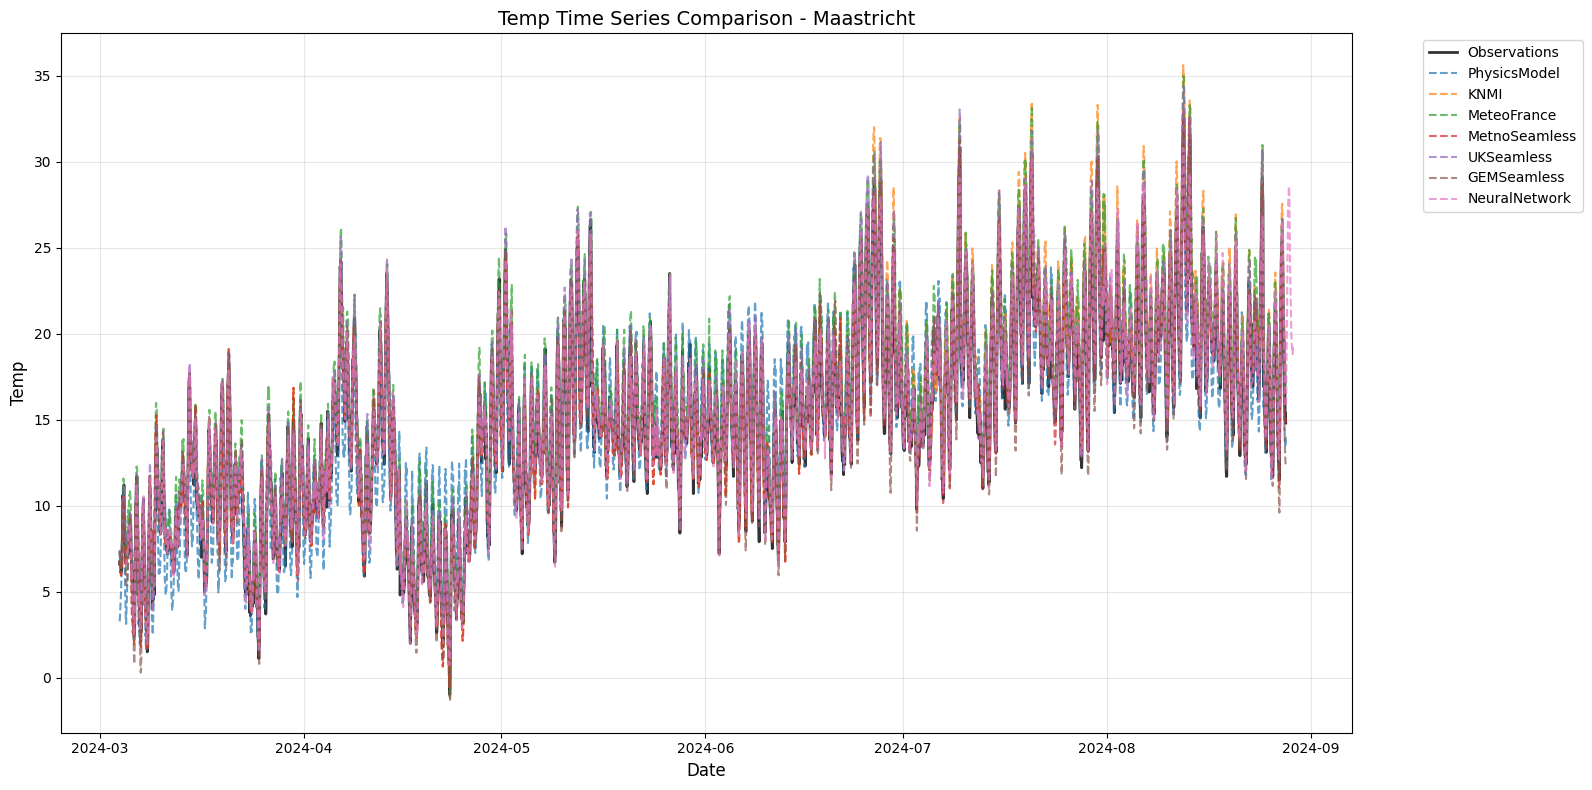

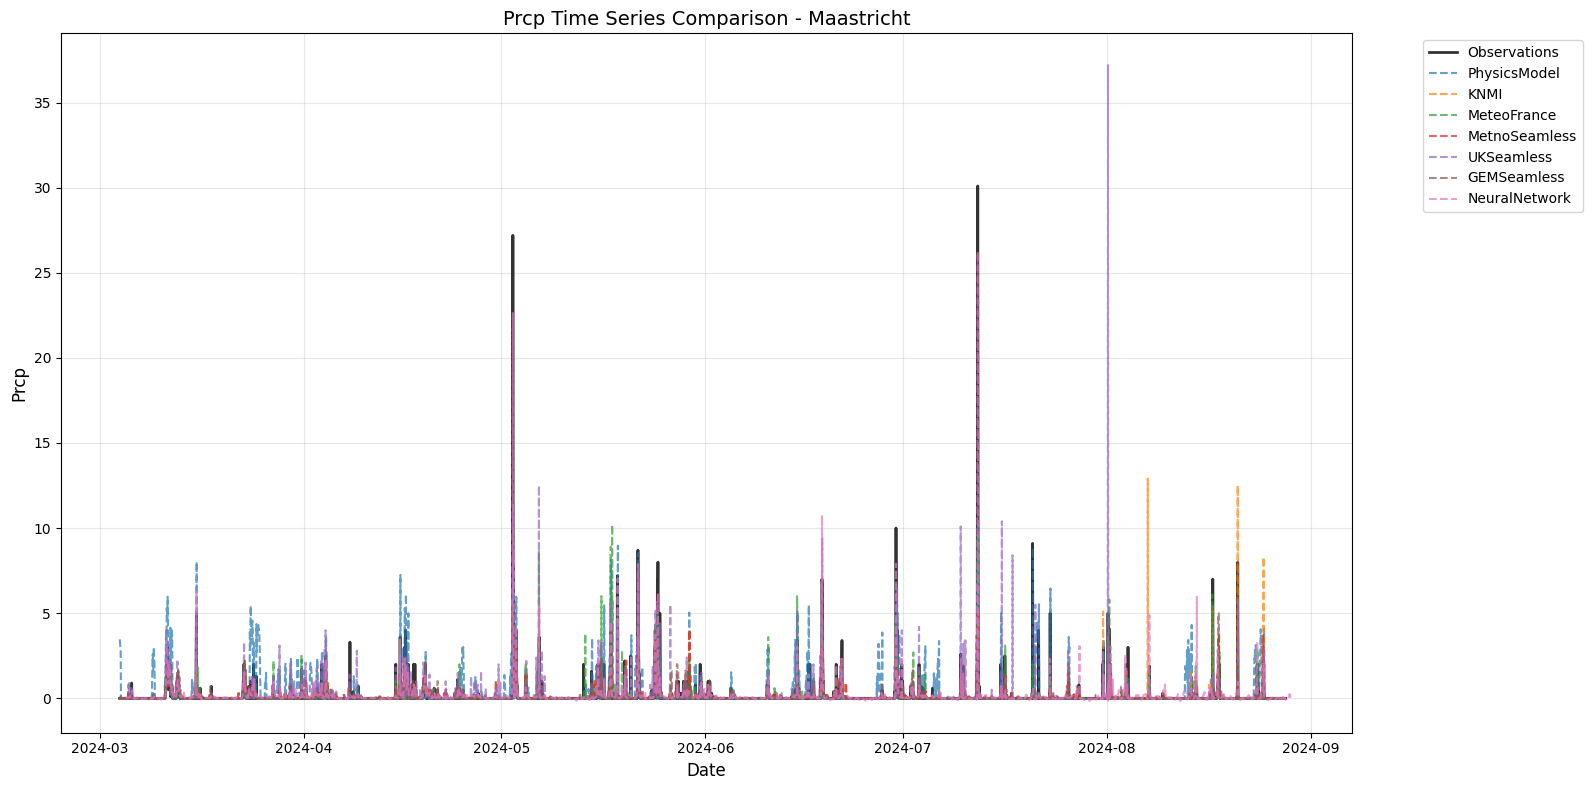

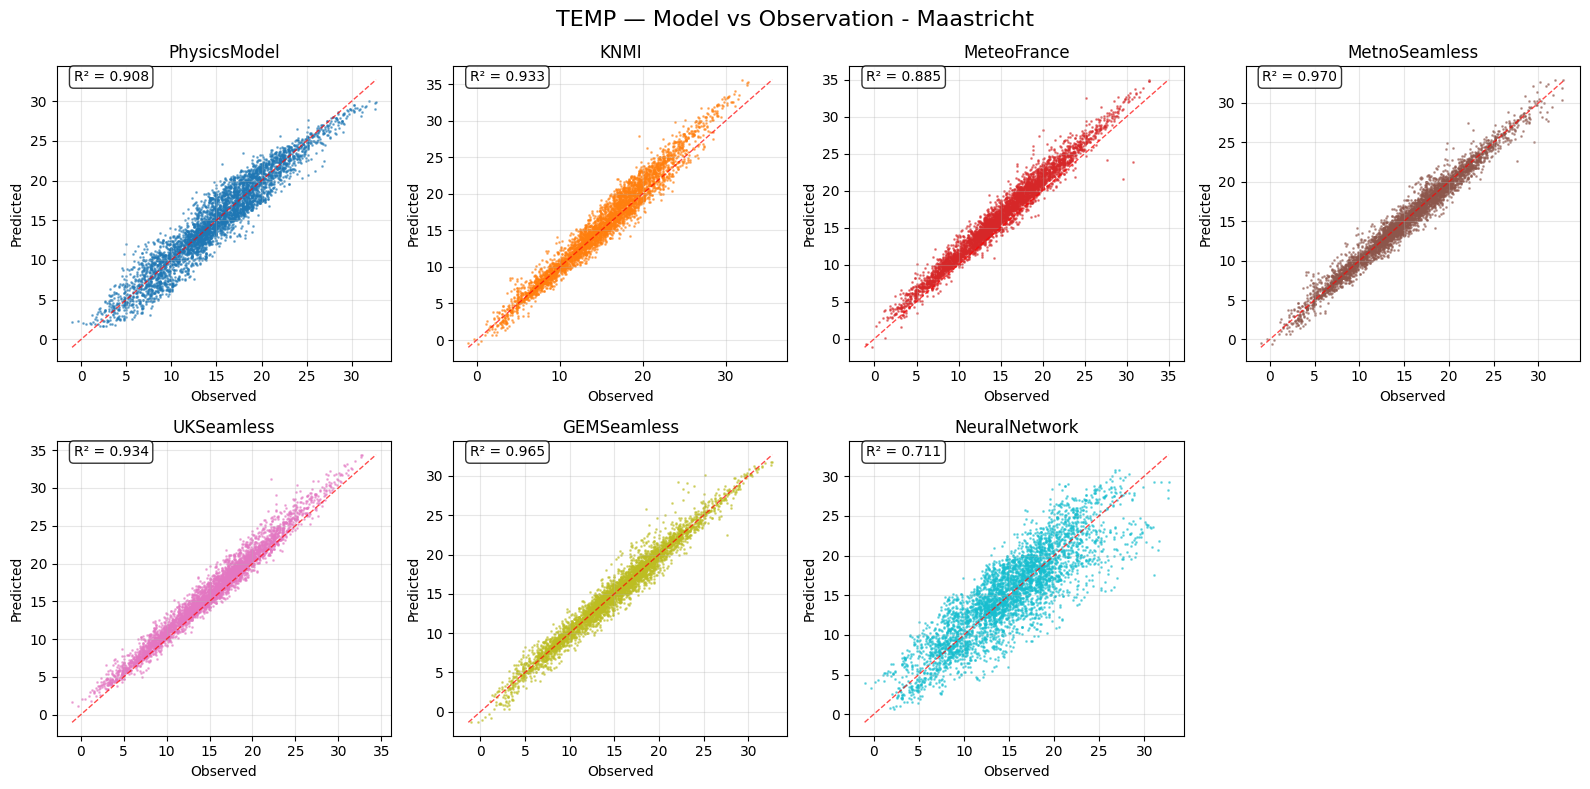

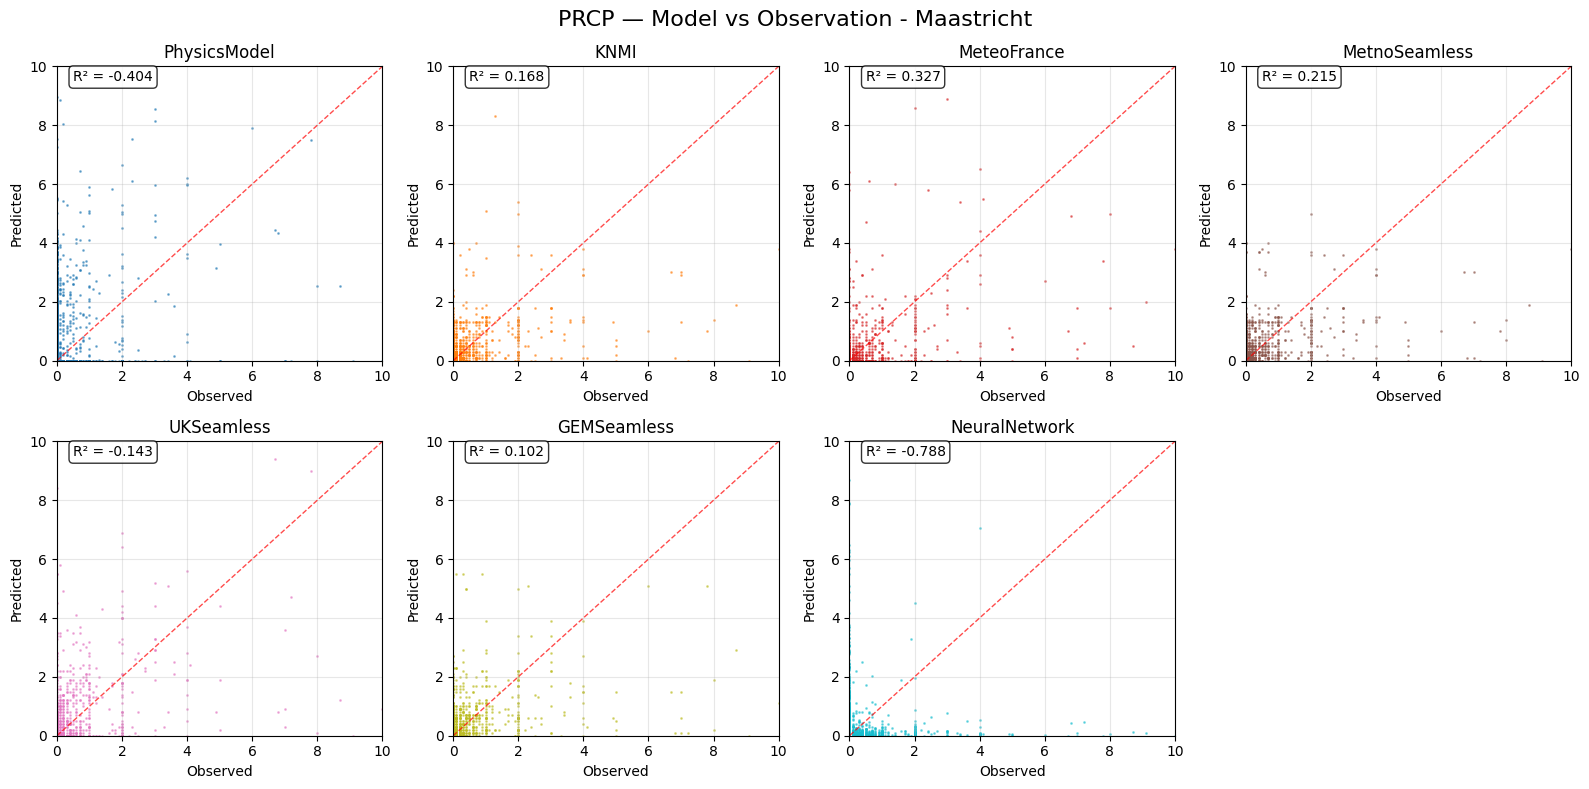

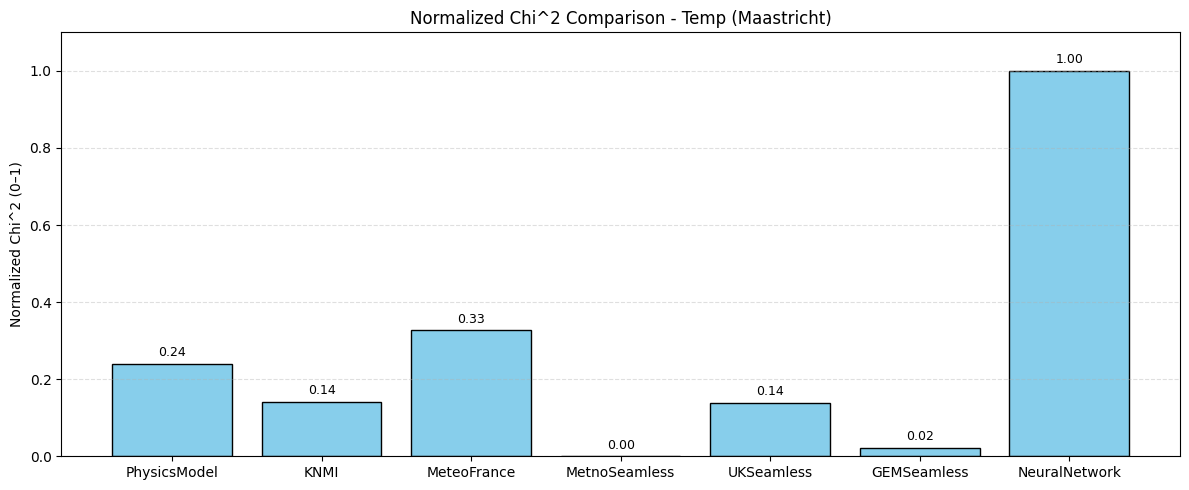

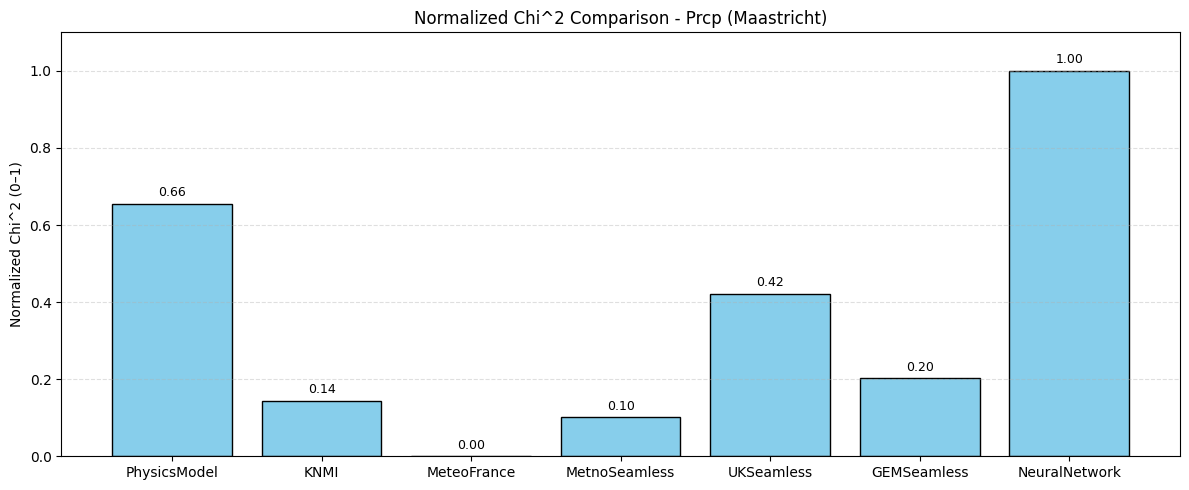

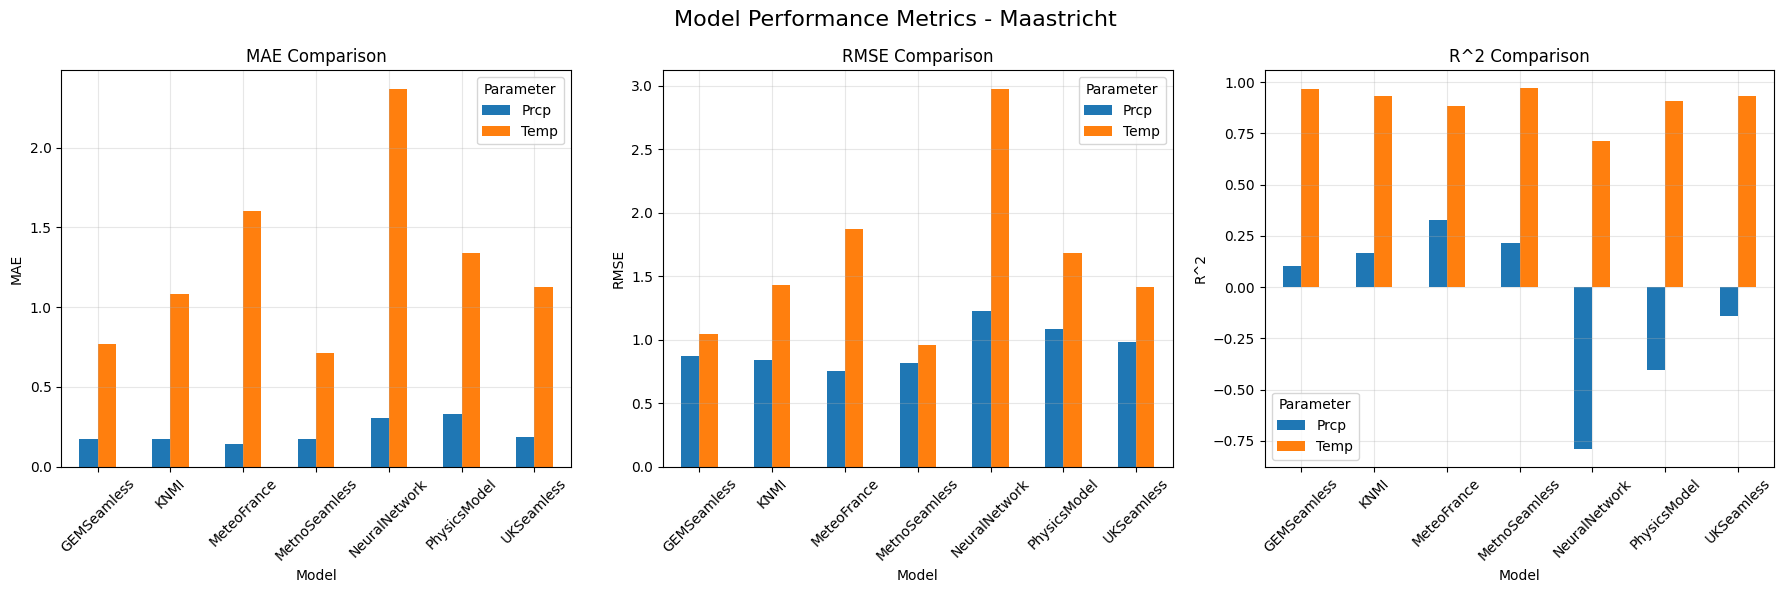

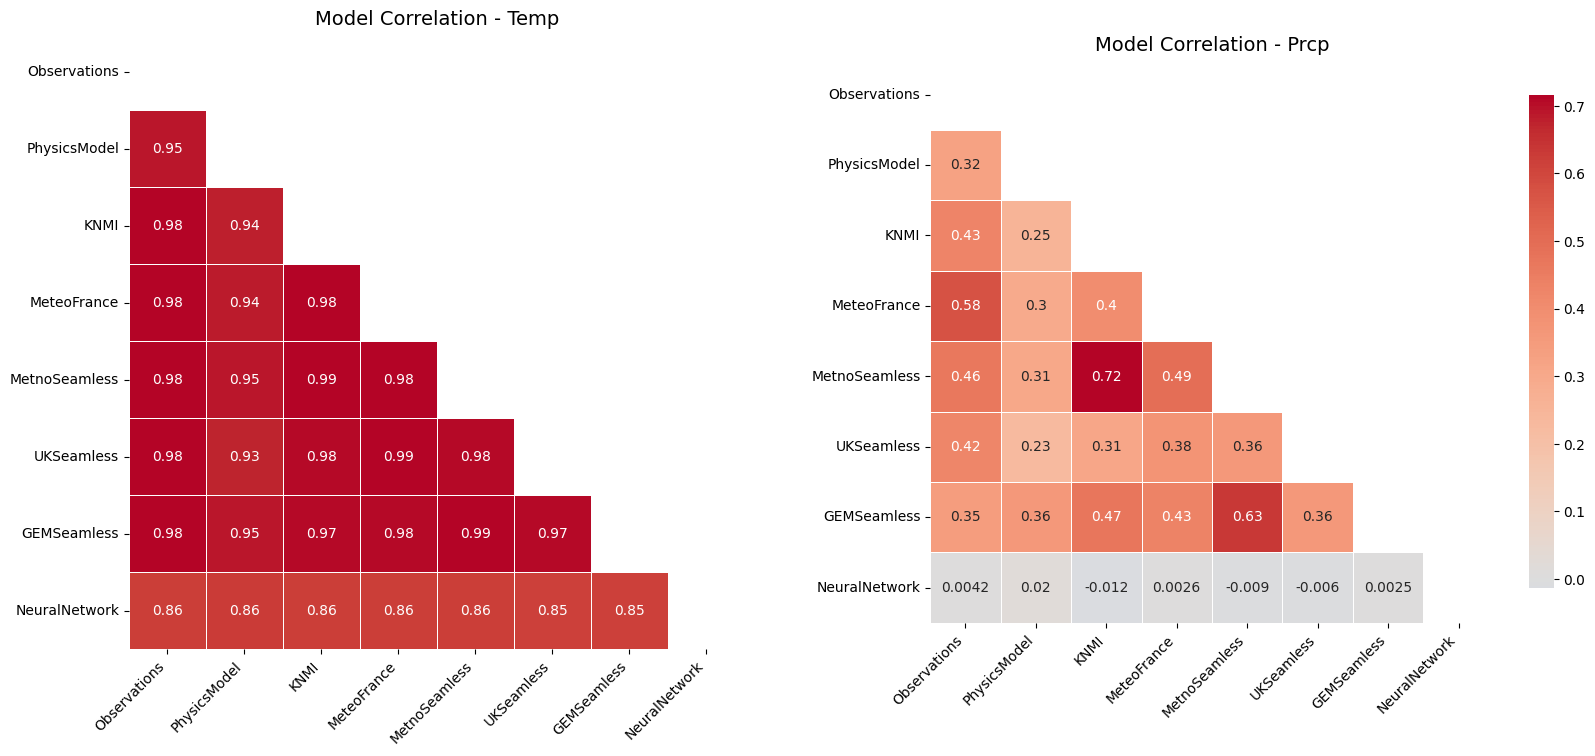

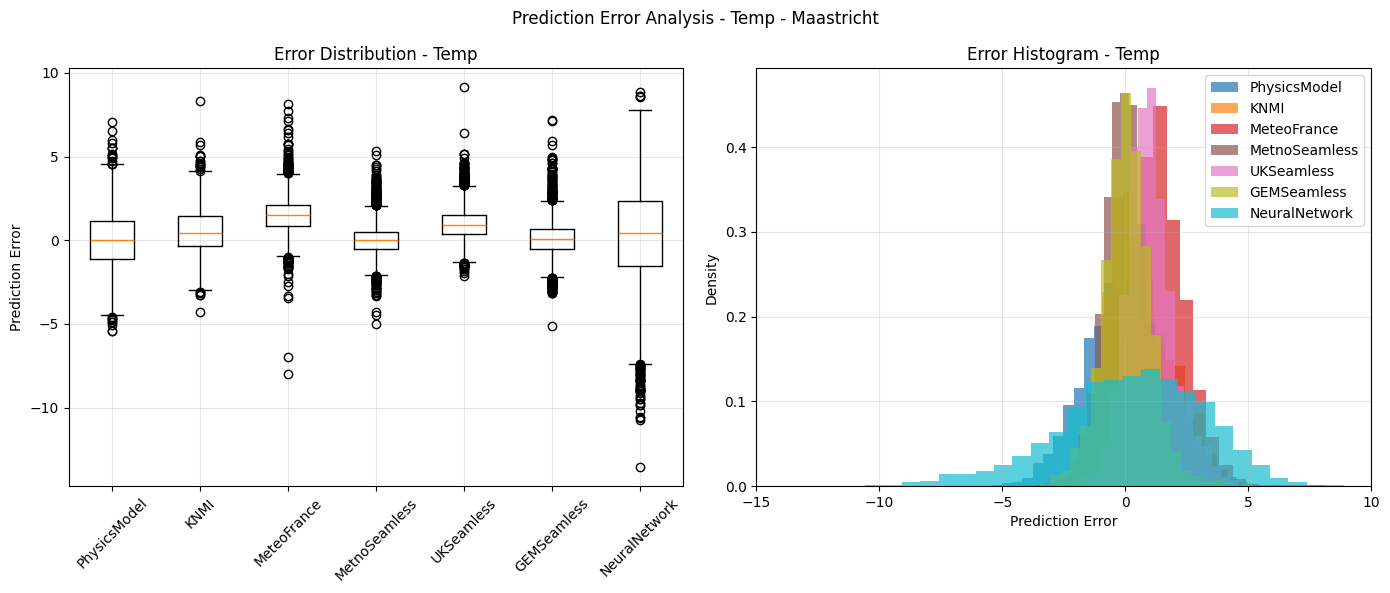

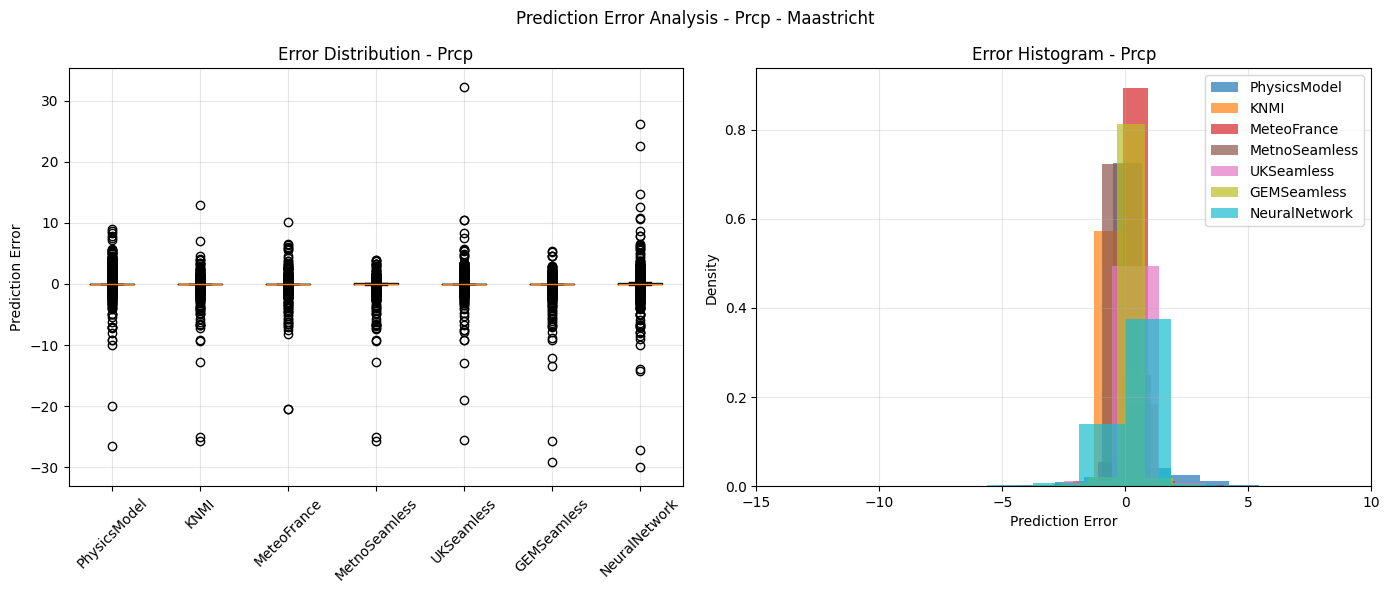

In [54]:
visualize_model_comparisons(weather_data, weather_data.get_model_names(), 
                           'Maastricht', TARGET_PARAMS)

Functions for performing the Diebold Mariano and b vs. c test.

In [55]:
# Function to process and clean data once for all comparisons
def process_and_clean_data(weather_data, location, target_params):

    model_names = weather_data.get_model_names()
    forecast_models = [m for m in model_names if m != 'Observational']

    cleaned_data = {}

    for param in target_params:

        # Get observational data
        obs_data = weather_data.get_parameter('Observational', location, param)
        obs_array = np.array(obs_data)

        # Get all model data
        model_data = {}
        for model in forecast_models:
            model_data[model] = np.array(weather_data.get_parameter(model, location, param))

        # Find minimum common length for alignment
        all_lengths = [len(obs_array)] + [len(model_data[model]) for model in forecast_models]
        min_common_length = min(all_lengths)

        # Align data
        obs_aligned = obs_array[:min_common_length]
        aligned_model_data = {model: model_data[model][:min_common_length] for model in forecast_models}

        cleaned_data[param] = {
            'obs_aligned': obs_aligned,
            'aligned_model_data': aligned_model_data,
            'forecast_models': forecast_models,
            'common_length': min_common_length,
            'pairwise_cleaned': {}
        }

        for model1, model2 in permutations(forecast_models, 2):
            data1 = aligned_model_data[model1]
            data2 = aligned_model_data[model2]
            obs_param = obs_aligned

            combined_mask = ~(np.isnan(obs_param) | np.isnan(data1) | np.isnan(data2))

            obs_clean = obs_param[combined_mask]
            model1_clean = data1[combined_mask]
            model2_clean = data2[combined_mask]

            comparison_key = f"{model1}_vs_{model2}"
            cleaned_data[param]['pairwise_cleaned'][comparison_key] = {
                'obs_clean': obs_clean,
                'model1_clean': model1_clean,
                'model2_clean': model2_clean,
                'model1_name': model1,
                'model2_name': model2,
                'n_samples': len(obs_clean),
                'combined_mask': combined_mask
            }

            print(f"  {model1} vs {model2}: {len(obs_clean)} valid points")

    return cleaned_data



# Function for running the statistical tests on all model pairs
def run_tests(cleaned_data, target_params, alpha=0.05):

    results = {
        'diebold_mariano': [],
        'b_vs_c': [],
        'summary': []
    }

    for param in target_params:
        if param not in cleaned_data:
            continue
        
        # Get the cleaned data
        pairwise_cleaned = cleaned_data[param]['pairwise_cleaned']

        for comparison_key, data in pairwise_cleaned.items():
            obs_clean = data['obs_clean']
            model1_clean = data['model1_clean']
            model2_clean = data['model2_clean']
            model1_name = data['model1_name']
            model2_name = data['model2_name']
            n_samples = data['n_samples']

            # Calculate the statistical results
            t_stat, p_val = b_vs_c_test(obs_clean, model1_clean, model2_clean)
            dm_stat, dm_p_val = diebold_mariano_test(obs_clean, model1_clean, model2_clean)

            if t_stat is not None:
                results['b_vs_c'].append({
                    'model1': model1_name,
                    'model2': model2_name,
                    'parameter': param,
                    't_statistic': t_stat,
                    'p_value': p_val,
                    'significant': p_val < alpha,
                    'better_model': model1_name if t_stat < 0 else model2_name if p_val < alpha else 'No difference',
                    'n_samples': n_samples
                })

            if dm_stat is not None:
                results['diebold_mariano'].append({
                    'model1': model1_name,
                    'model2': model2_name,
                    'parameter': param,
                    'dm_statistic': dm_stat,
                    'p_value': dm_p_val,
                    'significant': dm_p_val < alpha,
                    'better_model': model2_name if dm_stat > 0 else model1_name if dm_p_val < alpha else 'No difference',
                    'n_samples': n_samples
                })

    return results



# Function for the B vs. C test
def b_vs_c_test(obs_clean, model1_clean, model2_clean):
    from scipy.stats import ttest_rel

    obs_clean = np.asarray(obs_clean)
    model1_clean = np.asarray(model1_clean)
    model2_clean = np.asarray(model2_clean)

    error1 = np.abs(model1_clean - obs_clean)
    error2 = np.abs(model2_clean - obs_clean)

    t_stat, p_val = ttest_rel(error1, error2)

    return t_stat, p_val



# Function for the Diebold Mariano test
def diebold_mariano_test(obs_clean, model1_clean, model2_clean):

    obs_clean = np.array(obs_clean)
    model1_clean = np.array(model1_clean)
    model2_clean = np.array(model2_clean)

    e1 = (obs_clean - model1_clean) ** 2
    e2 = (obs_clean - model2_clean) ** 2
    d = e1 - e2

    mean_d = np.mean(d)
    N = len(d)
    gamma0 = np.var(d, ddof=1)

    if gamma0 == 0:
        return None, None

    var_d = gamma0
    dm_stat = mean_d / np.sqrt(var_d / N)
    p_value = 2 * stats.norm.cdf(-abs(dm_stat))

    return dm_stat, p_value



# Function for the logic of the analysis
def run_complete_analysis(weather_data, location, target_params, alpha=0.05, save_plots=False):

    cleaned_data = process_and_clean_data(weather_data, location, target_params)
    
    test_results = run_tests(cleaned_data, target_params, alpha)
    
    plot_statistical_test_results(test_results, location, target_params)
    plot_test_agreement(test_results, location, target_params)
    
    return test_results, cleaned_data



# Function for creating the matrix for comparing the models
def create_triangular_matrix_directional(df, index_col, columns_col, values_col, param_name):

    all_models = sorted(set(df[index_col].unique()) | set(df[columns_col].unique()))
    matrix = pd.DataFrame(np.nan, index=all_models, columns=all_models, dtype=float)

    # Fill diagonal with 1's
    if values_col == 'p_value':
        np.fill_diagonal(matrix.values, 1.0)
    else:
        np.fill_diagonal(matrix.values, 0.0)

    lookup = {(row[index_col], row[columns_col]): row[values_col] for _, row in df.iterrows()}

    for i, model1 in enumerate(all_models):
        for j, model2 in enumerate(all_models):
            if i < j:
                if (model1, model2) in lookup:
                    matrix.at[model1, model2] = lookup[(model1, model2)]
                elif (model2, model1) in lookup:
                    val = lookup[(model2, model1)]
                    if values_col in ['t_statistic', 'dm_statistic']:
                        matrix.at[model1, model2] = -val 
                    elif values_col == 'p_value':
                        matrix.at[model1, model2] = val 
            elif i == j:
                continue
            else:
                continue

    return matrix



# Function for plotting the statistical test results
def plot_statistical_test_results(test_results, location, target_params):

    df_bvc = pd.DataFrame(test_results['b_vs_c'])
    df_dm = pd.DataFrame(test_results['diebold_mariano'])

    fig_t, axes_t = plt.subplots(1, len(target_params), figsize=(8 * len(target_params), 8))
    if len(target_params) == 1:
        axes_t = [axes_t]

    for ax, param in zip(axes_t, target_params):
        param_bvc = df_bvc[df_bvc['parameter'] == param]
        if param_bvc.empty:
            ax.axis('off')
            ax.set_title(f'No T-test data for {param}')
            continue

        t_stat_matrix = create_triangular_matrix_directional(param_bvc, 'model1', 'model2', 't_statistic', param)
        t_matrix_display = t_stat_matrix.mask(np.tril(np.ones_like(t_stat_matrix, dtype=bool), k=-1))

        sns.heatmap(t_matrix_display, annot=True, cmap='RdBu_r', center=0,
                    ax=ax, cbar_kws={'label': 'T-statistic'}, fmt='.3f',
                    square=True, linewidths=0.5, cbar=True)
        ax.set_title(f'T-statistic - {param}')
        ax.set_ylabel('Model A')
        ax.set_xlabel('Model B')

    fig_t.suptitle(f'B vs C Test Statistics - {location}\n(Negative = Model A better, Positive = Model B better)', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    fig_dm, axes_dm = plt.subplots(1, len(target_params), figsize=(8 * len(target_params), 8))
    if len(target_params) == 1:
        axes_dm = [axes_dm]

    for ax, param in zip(axes_dm, target_params):
        param_dm = df_dm[df_dm['parameter'] == param]
        if param_dm.empty:
            ax.axis('off')
            ax.set_title(f'No DM data for {param}')
            continue

        dm_stat_matrix = create_triangular_matrix_directional(param_dm, 'model1', 'model2', 'dm_statistic', param)
        dm_matrix_display = dm_stat_matrix.mask(np.tril(np.ones_like(dm_stat_matrix, dtype=bool), k=-1))

        sns.heatmap(dm_matrix_display, annot=True, cmap='RdBu_r', center=0,
                    ax=ax, cbar_kws={'label': 'DM Statistic'}, fmt='.3f',
                    square=True, linewidths=0.5, cbar=True)
        ax.set_title(f'DM Statistic - {param}')
        ax.set_ylabel('Model A')
        ax.set_xlabel('Model B')

    fig_dm.suptitle(f'Diebold-Mariano Test Statistics - {location}\n(Negative = Model A better, Positive = Model B better)', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()



# Function for seeing  if the DM and B vs. C test agree or not
def plot_test_agreement(test_results, location, target_params):

    df_bvc = pd.DataFrame(test_results['b_vs_c'])
    df_dm = pd.DataFrame(test_results['diebold_mariano'])

    n_params = len(target_params)
    if n_params == 0:
        print("No parameters to plot.")
        return

    fig, axes = plt.subplots(1, n_params, figsize=(12 * n_params, 10), squeeze=False)
    axes = axes[0] 

    legend_elements = [
        plt.Rectangle((0, 0), 1, 1, facecolor='lightgray', label='Both: No difference'),
        plt.Rectangle((0, 0), 1, 1, facecolor='gold', label='One test inconclusive'),
        plt.Rectangle((0, 0), 1, 1, facecolor='lightgreen', label='Both tests agree'),
        plt.Rectangle((0, 0), 1, 1, facecolor='lightcoral', label='Tests disagree')
    ]

    for idx, param in enumerate(target_params):
        param_bvc = df_bvc[df_bvc['parameter'] == param].copy()
        param_dm = df_dm[df_dm['parameter'] == param].copy()

        param_bvc['comparison'] = param_bvc['model1'] + ' vs ' + param_bvc['model2']
        param_dm['comparison'] = param_dm['model1'] + ' vs ' + param_dm['model2']

        merged = param_bvc.merge(param_dm, on='comparison', suffixes=('_bvc', '_dm'))

        agreement_data = []
        for _, row in merged.iterrows():
            bvc_better = row['better_model_bvc'] if row['significant_bvc'] else 'No difference'
            dm_better = row['better_model_dm'] if row['significant_dm'] else 'No difference'

            if bvc_better == 'No difference' and dm_better == 'No difference':
                color_code = 0
            elif bvc_better == 'No difference' or dm_better == 'No difference':
                color_code = 1
            elif bvc_better == dm_better:
                color_code = 2
            else:
                color_code = 3

            agreement_data.append({
                'model1': row['model1_bvc'],
                'model2': row['model2_bvc'],
                'color_code': color_code
            })

        if not agreement_data:
            continue

        df_agreement = pd.DataFrame(agreement_data)
        all_models = sorted(set(df_agreement['model1']) | set(df_agreement['model2']))
        agreement_matrix = pd.DataFrame(-1, index=all_models, columns=all_models, dtype=int)
        np.fill_diagonal(agreement_matrix.values, 0)

        for _, row in df_agreement.iterrows():
            m1, m2 = row['model1'], row['model2']
            code = row['color_code']
            if m1 in all_models and m2 in all_models:
                i, j = all_models.index(m1), all_models.index(m2)
                if j > i:
                    agreement_matrix.iloc[i, j] = code
                elif i > j:
                    agreement_matrix.iloc[j, i] = code

        mask_lower = np.tril(np.ones_like(agreement_matrix, dtype=bool), k=-1)
        agreement_display = agreement_matrix.mask(mask_lower)

        annot_labels = {0: 'Both:\nNo diff', 1: 'One test\ninconclusive', 2: 'Both\nagree', 3: 'Tests\ndisagree', -1: ''}
        annot_matrix = agreement_display.copy().astype(str)
        for i in range(len(all_models)):
            for j in range(len(all_models)):
                val = agreement_display.iloc[i, j]
                if pd.notna(val):
                    annot_matrix.iloc[i, j] = annot_labels.get(int(val), '')

        colors = ['lightgray', 'gold', 'lightgreen', 'lightcoral']
        cmap = plt.cm.colors.ListedColormap(colors)

        sns.heatmap(agreement_display, annot=annot_matrix, fmt='', cmap=cmap,
                    ax=axes[idx], square=True, linewidths=0.5, cbar=False,
                    vmin=-0.5, vmax=3.5)

        axes[idx].set_title(f'Agreement - {param}', fontsize=14)
        axes[idx].set_xlabel('Model B')
        axes[idx].set_ylabel('Model A')

    plt.tight_layout(rect=[0, 0, 0.97, 0.95]) 
    plt.show()

        

  PhysicsModel vs KNMI: 4253 valid points
  PhysicsModel vs MeteoFrance: 4253 valid points
  PhysicsModel vs MetnoSeamless: 4253 valid points
  PhysicsModel vs UKSeamless: 4253 valid points
  PhysicsModel vs GEMSeamless: 4253 valid points
  PhysicsModel vs NeuralNetwork: 4253 valid points
  KNMI vs PhysicsModel: 4253 valid points
  KNMI vs MeteoFrance: 4253 valid points
  KNMI vs MetnoSeamless: 4253 valid points
  KNMI vs UKSeamless: 4253 valid points
  KNMI vs GEMSeamless: 4253 valid points
  KNMI vs NeuralNetwork: 4253 valid points
  MeteoFrance vs PhysicsModel: 4253 valid points
  MeteoFrance vs KNMI: 4253 valid points
  MeteoFrance vs MetnoSeamless: 4253 valid points
  MeteoFrance vs UKSeamless: 4253 valid points
  MeteoFrance vs GEMSeamless: 4253 valid points
  MeteoFrance vs NeuralNetwork: 4253 valid points
  MetnoSeamless vs PhysicsModel: 4253 valid points
  MetnoSeamless vs KNMI: 4253 valid points
  MetnoSeamless vs MeteoFrance: 4253 valid points
  MetnoSeamless vs UKSeamless: 

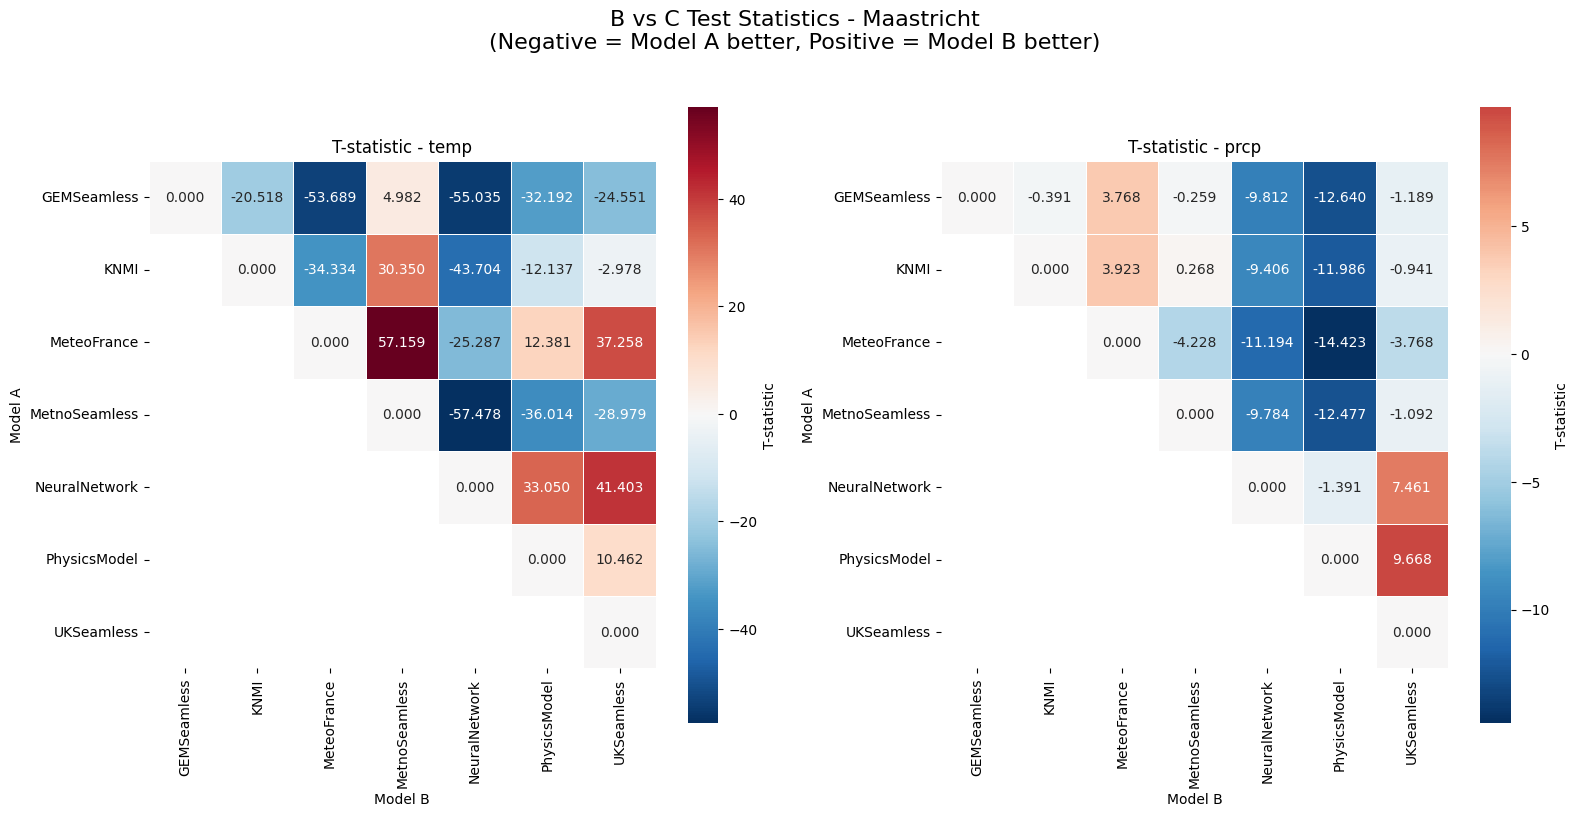

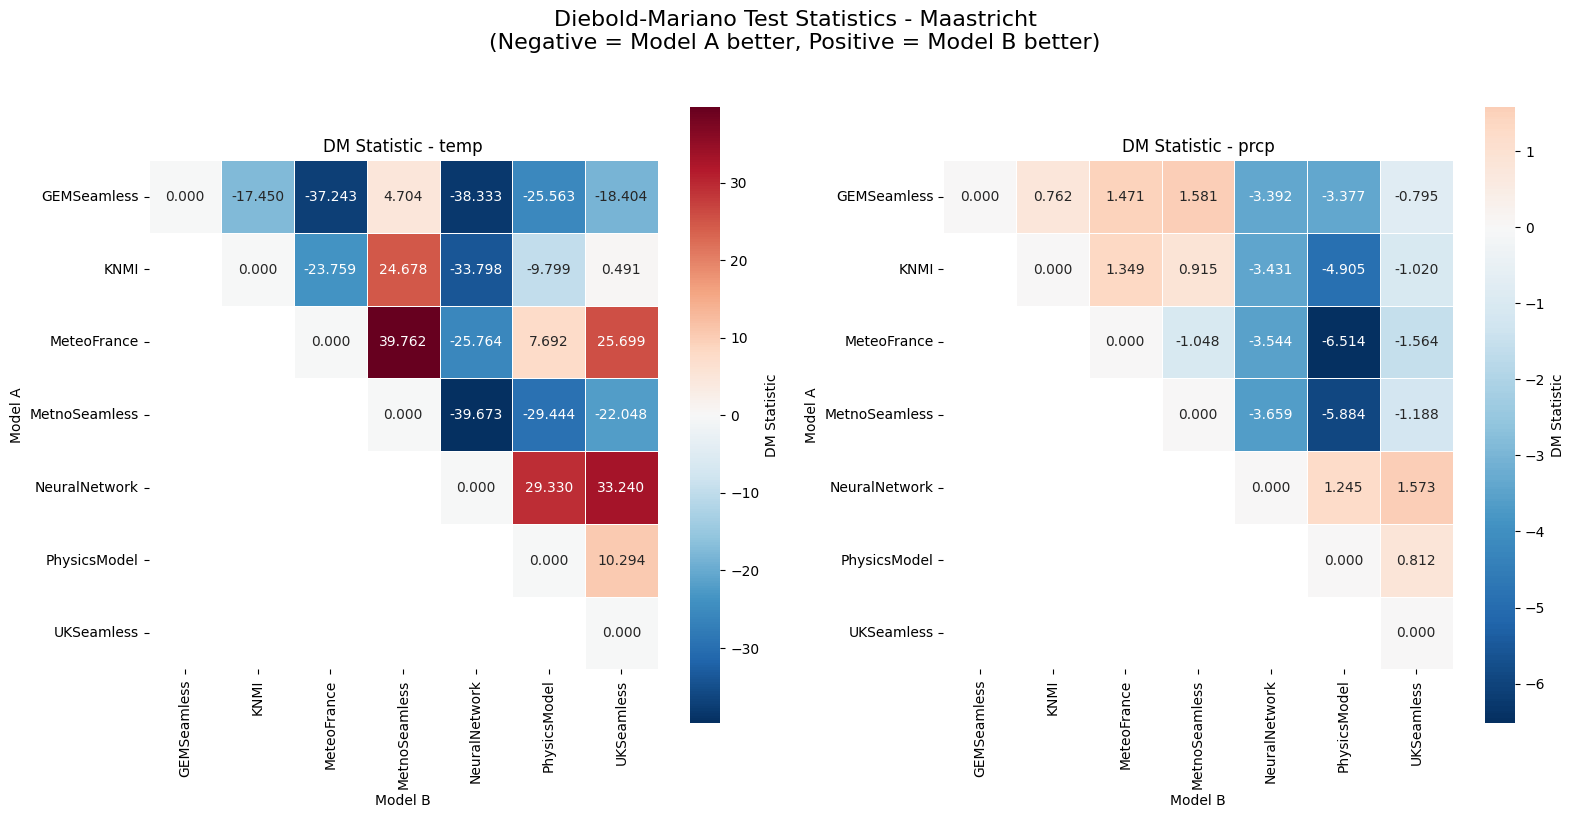

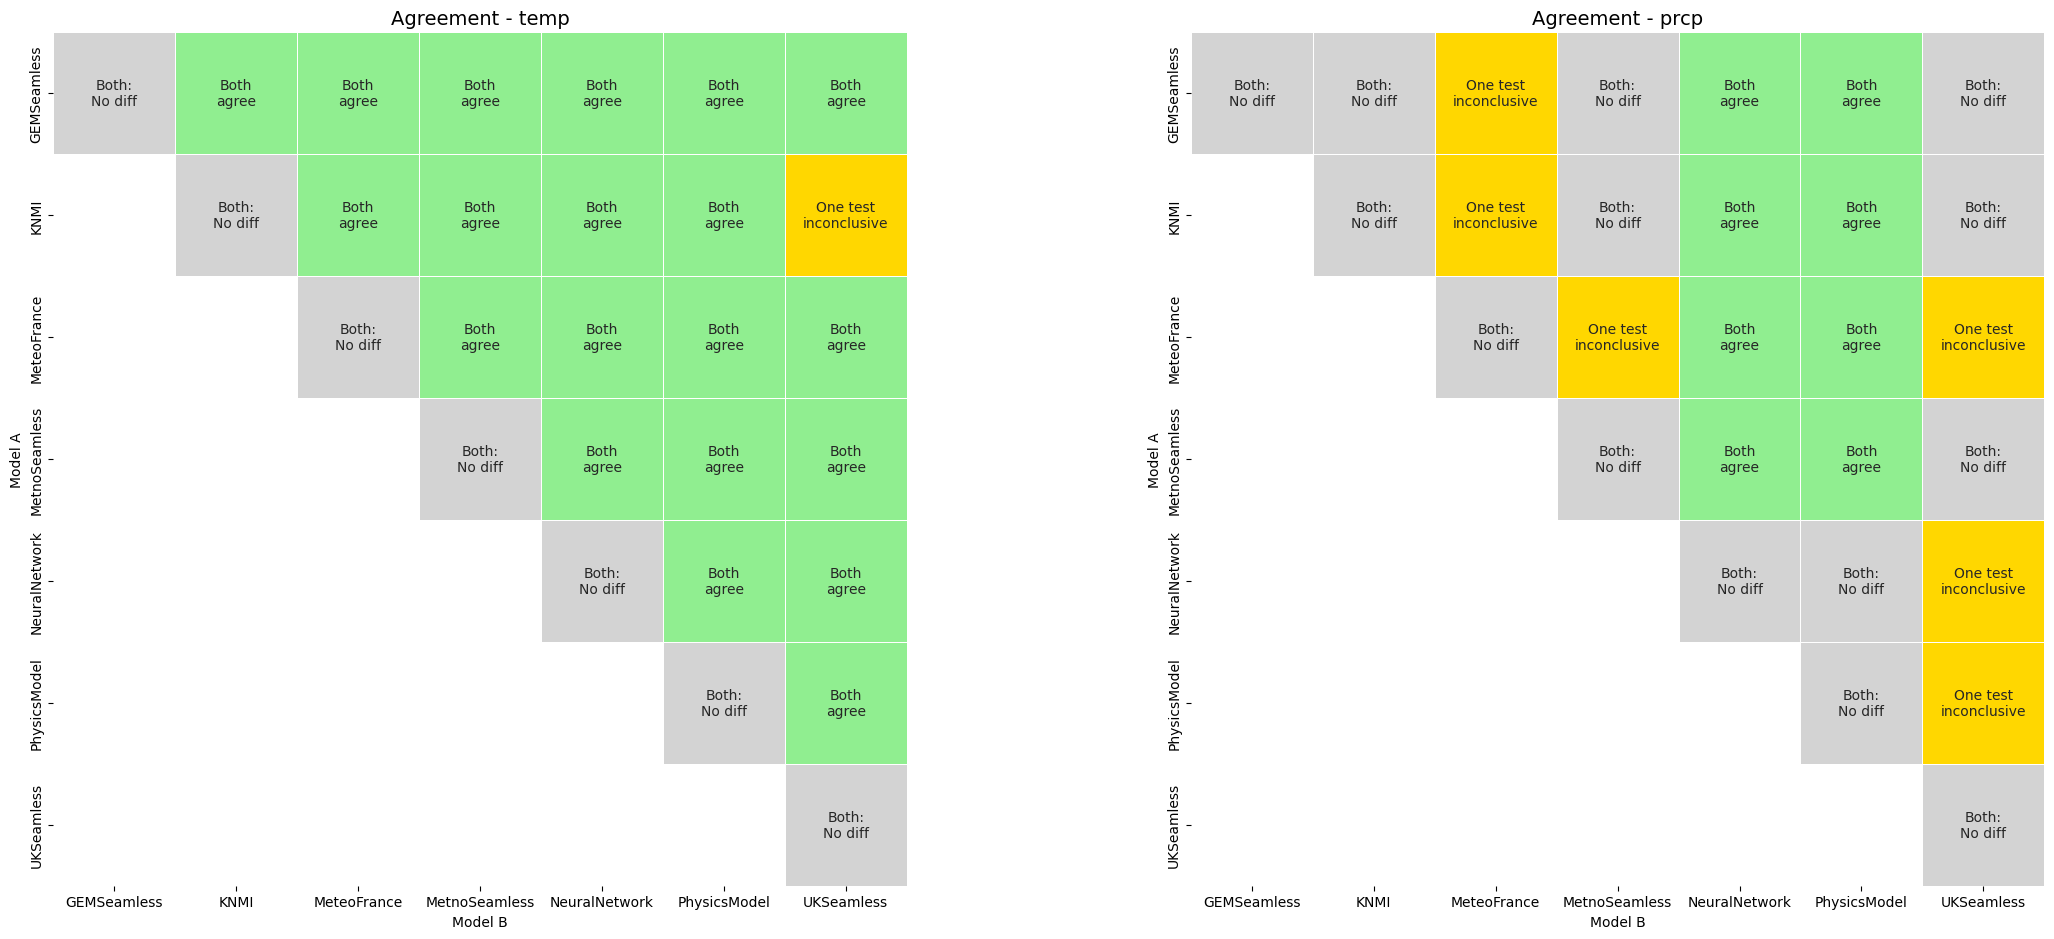

In [56]:
test_results, cleaned_data = run_complete_analysis(
    weather_data, 'Maastricht', TARGET_PARAMS, 
    alpha=0.05, 
    save_plots=False
)

Functions for performing the bias and Q and Q test

In [57]:
# Function for calculating the errors of the models with respect to the observational data
def calculate_model_errors(weather_data, model_names, location, target_params):

    errors_dict = {}
    
    # Get the observational data
    obs_data = {}
    for param in target_params:
        obs_data[param] = np.array(weather_data.get_parameter('Observational', location, param))

    # Get the models that are not the observational data
    for model_name in model_names:
        if model_name == 'Observational':
            continue
            
        errors_dict[model_name] = {}
        
        # Get the model data
        for param in target_params:
            model_data = np.array(weather_data.get_parameter(model_name, location, param))
            
            # Determine the shortest length
            min_len = min(len(obs_data[param]), len(model_data))
                
            # Trim the arrays to the shortest lengths
            obs_subset = obs_data[param][:min_len]
            model_subset = model_data[:min_len]
            
            # Only use non-nan values
            valid_mask = ~(np.isnan(obs_subset) | np.isnan(model_subset))
                
            obs_clean = obs_subset[valid_mask]
            model_clean = model_subset[valid_mask]
            
            # Calculate the error
            errors = model_clean - obs_clean
            errors_dict[model_name][param] = errors
    
    return errors_dict



# Function for determining the systematic bias
def test_systematic_bias(errors, param_name, model_name, alpha=0.05):

    results = {}
    
    # Only use the non-nan values for the errors
    clean_errors = errors[~np.isnan(errors)]
    
    # calculate the mean, standar deviation and the length of the errors
    mean_error = np.mean(clean_errors)
    std_error = np.std(clean_errors)
    n = len(clean_errors)
    
    results['mean_error'] = mean_error
    results['std_error'] = std_error
    results['n_samples'] = n
    
    # Perform a t test on the error
    t_stat, t_pvalue = stats.ttest_1samp(clean_errors, 0)
    results['t_test'] = {
        'statistic': t_stat,
        'p_value': t_pvalue,
        'significant': t_pvalue < alpha,
        'interpretation': 'Systematic bias detected' if t_pvalue < alpha else 'No systematic bias'
    }
    
    # Count the number of positive and negative errors
    positive_errors = np.sum(clean_errors > 0)
    negative_errors = np.sum(clean_errors < 0)
    zero_errors = np.sum(clean_errors == 0)

    # Perform a binomial test to see if there are more positive or negative errors
    sign_pvalue = 2 * min(
        stats.binom.cdf(positive_errors, positive_errors + negative_errors, 0.5),
        1 - stats.binom.cdf(positive_errors - 1, positive_errors + negative_errors, 0.5)
    )
    
    results['sign_test'] = {
        'positive_errors': positive_errors,
        'negative_errors': negative_errors,
        'zero_errors': zero_errors,
        'p_value': sign_pvalue,
        'significant': sign_pvalue < alpha,
        'interpretation': 'Systematic bias detected' if sign_pvalue < alpha else 'No systematic bias'
    }
    
    return results



# Function for determining the Kolmogorov Smirnov test
def test_normality(errors, param_name, model_name, alpha=0.05):

    results = {}
    clean_errors = errors[~np.isnan(errors)]
    fitted_mean = np.mean(clean_errors)
    fitted_std = np.std(clean_errors)
    ks_stat, ks_p = kstest(clean_errors, lambda x: stats.norm.cdf(x, fitted_mean, fitted_std))
    results['kolmogorov_smirnov'] = {
        'statistic': ks_stat,
        'p_value': ks_p,
        'is_normal': ks_p > alpha
    }

    return results



# Function for plotting the error distribution with a fit and the Q-Q test
def plot_error_distributions(errors_dict, target_params, location, save_plots=False):

    model_names = list(errors_dict.keys())
    n_models = len(model_names)
    n_params = len(target_params)
    
    plt.style.use('default')
    colors = plt.cm.Set1(np.linspace(0, 1, n_models))
    
    for param in target_params:
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        fig.suptitle(f'Error Distribution Analysis - {param.title()} ({location})', fontsize=16, fontweight='bold')

        all_errors = []
        valid_models = []
        
        # Clean the errors
        for model_name in model_names:
            if param in errors_dict[model_name] and len(errors_dict[model_name][param]) > 0:
                clean_errors = errors_dict[model_name][param]
                clean_errors = clean_errors[~np.isnan(clean_errors)]
                if len(clean_errors) > 0:
                    all_errors.append(clean_errors)
                    valid_models.append(model_name)

        # Histrogram for with a fitted curve
        ax1 = axes[0]
        for i, (errors, model_name) in enumerate(zip(all_errors, valid_models)):
            ax1.hist(errors, bins=50, alpha=0.6, density=True, 
                    label=f'{model_name}', color=colors[i])
            
            # Fit the best Gaussian fit to the error distribution
            mu, sigma = stats.norm.fit(errors)
            x = np.linspace(errors.min(), errors.max(), 100)
            ax1.plot(x, stats.norm.pdf(x, mu, sigma), 
                    color=colors[i], linestyle='--', linewidth=2)
        
        ax1.set_xlabel(f'{param.title()} Error')
        ax1.set_ylabel('Density')
        ax1.set_title('Error Histograms with Fitted Normal Curves')
        ax1.set_xlim([-15, 10])
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Plot the Q-Q test
        ax2 = axes[1]
        for i, (errors, model_name) in enumerate(zip(all_errors, valid_models)):
            stats.probplot(errors, dist="norm", plot=None)
            theoretical_quantiles = stats.norm.ppf(np.linspace(0.01, 0.99, len(errors)))
            sample_quantiles = np.sort(errors)
            ax2.scatter(theoretical_quantiles, sample_quantiles, 
                       alpha=0.6, label=model_name, color=colors[i], s=20)
        
        all_combined = np.concatenate(all_errors)
        min_val, max_val = np.min(all_combined), np.max(all_combined)
        ax2.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8)
        ax2.set_xlabel('Theoretical Quantiles')
        ax2.set_ylabel('Sample Quantiles')
        ax2.set_title('Q-Q Plot (Normal Distribution)')
        ax2.set_xlim([-5, 5])
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.show()



# Function for the logic of the error distribution analysis
def comprehensive_error_analysis(weather_data, model_names, location, target_params):
    errors_dict = calculate_model_errors(weather_data, model_names, location, target_params)
    plot_error_distributions(errors_dict, target_params, location)

Visualising the bias analysis and Q-Q test.

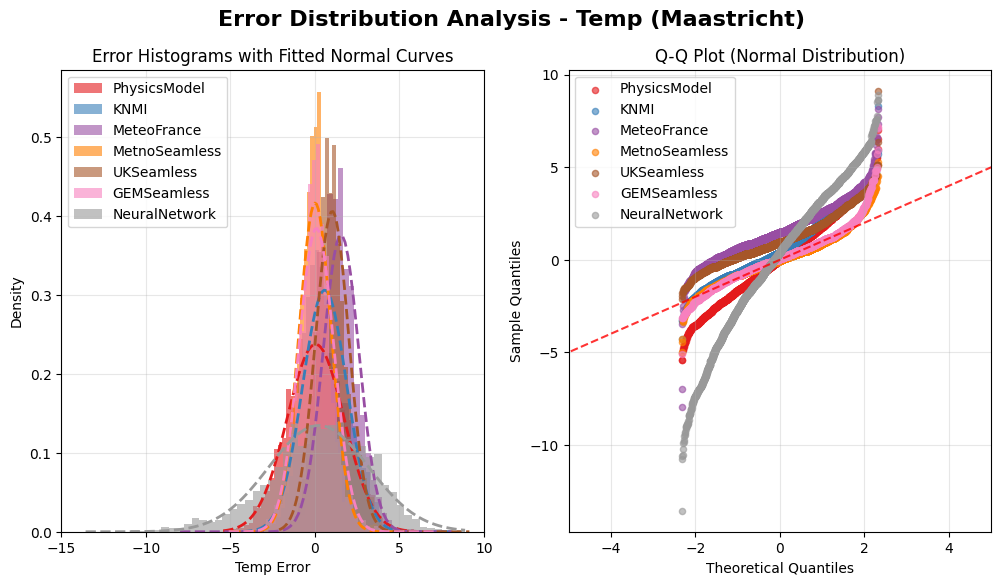

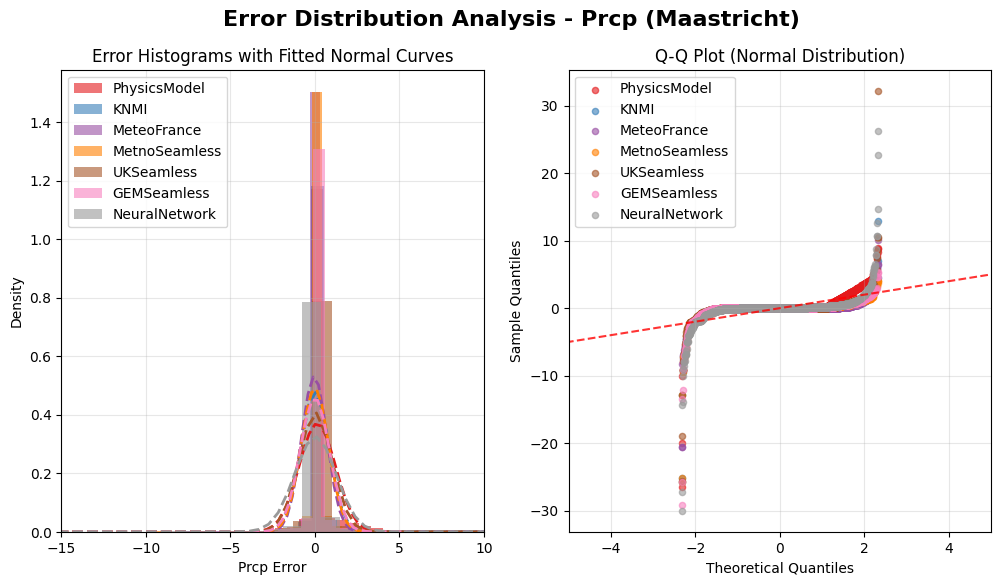

In [58]:
comprehensive_error_analysis(
    weather_data, 
    model_names_with_neural, 
    'Maastricht', 
    TARGET_PARAMS
)

Function for determining the biases

In [59]:
# Function for summarising the biases on the models
def summarize_biases(errors_dict):

    summary = {}
    for model_name, param_errors in errors_dict.items():
        summary[model_name] = {}
        for param, errors in param_errors.items():
            result = test_systematic_bias(errors, param_name=param, model_name=model_name)
            summary[model_name][param] = result['mean_error']
            
    return summary

Printing the biases for each model.

In [60]:
errors_dict = calculate_model_errors(weather_data, model_names_with_neural, 'Maastricht', TARGET_PARAMS)
bias_summary = summarize_biases(errors_dict)

# Print the biases for the models
for model, param_biases in bias_summary.items():
    print(f"\nModel: {model}")
    for param, bias in param_biases.items():
        print(f"  {param}: Bias = {bias:.3f}")


Model: PhysicsModel
  temp: Bias = 0.041
  prcp: Bias = 0.139

Model: KNMI
  temp: Bias = 0.582
  prcp: Bias = 0.001

Model: MeteoFrance
  temp: Bias = 1.543
  prcp: Bias = -0.040

Model: MetnoSeamless
  temp: Bias = 0.015
  prcp: Bias = -0.003

Model: UKSeamless
  temp: Bias = 1.022
  prcp: Bias = 0.031

Model: GEMSeamless
  temp: Bias = 0.088
  prcp: Bias = -0.006

Model: NeuralNetwork
  temp: Bias = 0.227
  prcp: Bias = 0.027
